# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 4  
data_points_exp = 20000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 4]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 503.83697509765625
iteration 0 loss 457.8285827636719


iteration 500 loss 1.4955623149871826


iteration 1000 loss 0.10944967716932297


iteration 1500 loss 0.05038858577609062


iteration 2000 loss 0.03017711080610752


iteration 2500 loss 0.019381821155548096


iteration 3000 loss 0.10572155565023422


iteration 3500 loss 0.012062106281518936


iteration 4000 loss 0.00859684869647026


iteration 4500 loss 0.015271465294063091


iteration 5000 loss 0.007990740239620209


iteration 5500 loss 0.005948352627456188


iteration 6000 loss 4.982420921325684


iteration 6500 loss 0.00514736445620656


iteration 7000 loss 0.004072421696037054


iteration 7500 loss 0.003915136680006981


iteration 8000 loss 0.003751463955268264


iteration 8500 loss 0.0036413592752069235


iteration 9000 loss 0.0033649078104645014


iteration 9500 loss 0.003087372053414583


iteration 10000 loss 0.002835856983438134


iteration 10500 loss 0.002648938214406371


iteration 11000 loss 0.0024843458086252213


iteration 11500 loss 0.0023341886699199677


iteration 12000 loss 0.002180141629651189


iteration 12500 loss 0.36718276143074036


iteration 13000 loss 0.002945834305137396


iteration 13500 loss 0.002275171922519803


iteration 14000 loss 0.0020549518521875143


iteration 14500 loss 0.001922668656334281


iteration 15000 loss 0.001813669572584331


iteration 15500 loss 0.001717403414659202


iteration 16000 loss 0.0016202311962842941


iteration 16500 loss 0.0015483140014111996


iteration 17000 loss 0.0694965347647667


iteration 17500 loss 0.3688952624797821


iteration 18000 loss 0.0013888143002986908


iteration 18500 loss 0.0013533489545807242


iteration 19000 loss 0.001315344125032425


iteration 19500 loss 0.0012722780229523778


iteration 20000 loss 0.22298315167427063


iteration 20500 loss 0.04128090664744377


iteration 21000 loss 0.0011768921976909041


iteration 21500 loss 0.0011347141116857529


iteration 22000 loss 0.0011168315540999174


iteration 22500 loss 0.0011027774307876825


iteration 23000 loss 1.1799460649490356


iteration 23500 loss 0.0025156422052532434


iteration 24000 loss 0.005073231179267168


iteration 24500 loss 0.7234207987785339


iteration 25000 loss 0.3963650166988373


iteration 25500 loss 0.0009184000664390624


iteration 26000 loss 0.0009089831146411598


iteration 26500 loss 0.0008989116176962852


iteration 27000 loss 0.000886373280081898


iteration 27500 loss 0.0008806180558167398


iteration 28000 loss 0.0008782905642874539


iteration 28500 loss 0.0008807876147329807


iteration 29000 loss 0.0008973297080956399


iteration 29500 loss 0.0011195464758202434


iteration 30000 loss 0.000753150787204504


iteration 30500 loss 0.0007625299040228128


iteration 31000 loss 0.0007720309076830745


iteration 31500 loss 0.0007944436511024833


iteration 32000 loss 0.0008617957937531173


iteration 32500 loss 0.0034554190933704376


iteration 33000 loss 0.000677080824971199


iteration 33500 loss 0.0006746460567228496


iteration 34000 loss 0.0006792003405280411


iteration 34500 loss 0.0007038606563583016


iteration 35000 loss 0.0009127873345278203


iteration 35500 loss 0.0006244418327696621


iteration 36000 loss 0.0006424873135983944


iteration 36500 loss 0.0006715534254908562


iteration 37000 loss 0.02248246967792511


iteration 37500 loss 0.0006081392639316618


iteration 38000 loss 0.0006243280367925763


iteration 38500 loss 0.0006411902140825987


iteration 39000 loss 0.0006299862870946527


iteration 39500 loss 0.0006088009686209261


iteration 40000 loss 0.000633781892247498


iteration 40500 loss 0.0012540011666715145


iteration 41000 loss 0.003845724742859602


iteration 41500 loss 0.0005269379471428692


iteration 42000 loss 0.0005291529814712703


iteration 42500 loss 0.0005343948723748326


iteration 43000 loss 0.0005484434659592807


iteration 43500 loss 0.0010429834946990013


iteration 44000 loss 0.0004905089153908193


iteration 44500 loss 0.0005162842571735382


iteration 45000 loss 0.0006262694951146841


iteration 45500 loss 0.00047063283273018897


iteration 46000 loss 0.0004802605544682592


iteration 46500 loss 0.0004851041594520211


iteration 47000 loss 0.0004920470528304577


iteration 47500 loss 0.0005351308500394225


iteration 48000 loss 0.32464733719825745


iteration 48500 loss 0.0004454416048247367


iteration 49000 loss 0.0004543556133285165


iteration 49500 loss 0.00048326366231776774


iteration 50000 loss 0.00042435064096935093


iteration 50500 loss 0.0004362438921816647


iteration 51000 loss 0.00046241015661507845


iteration 51500 loss 0.0004112744645681232


iteration 52000 loss 0.00042439179378561676


iteration 52500 loss 0.0004282775626052171


iteration 53000 loss 0.00043635896872729063


iteration 53500 loss 0.0004921723157167435


iteration 54000 loss 0.0003960441972594708


iteration 54500 loss 0.00040429781074635684


iteration 55000 loss 0.00042689594556577504


iteration 55500 loss 0.05867753177881241


iteration 56000 loss 0.00038622794090770185


iteration 56500 loss 0.0003874068206641823


iteration 57000 loss 0.00039176843711175025


iteration 57500 loss 0.0003984191862400621


iteration 58000 loss 0.010933118872344494


iteration 58500 loss 0.0003689949808176607


iteration 59000 loss 0.00037065925425849855


iteration 59500 loss 0.0003891923697665334


iteration 60000 loss 0.004414810799062252


iteration 60500 loss 0.0003618545306380838


iteration 61000 loss 0.0004071122966706753


iteration 61500 loss 0.000360861566150561


iteration 62000 loss 0.0003757866215892136


iteration 62500 loss 0.0003927181242033839


iteration 63000 loss 0.05042748153209686


iteration 63500 loss 0.0003477114369161427


iteration 64000 loss 0.0003506683569867164


iteration 64500 loss 0.00035807842505164444


iteration 65000 loss 0.0003610536514315754


iteration 65500 loss 0.0003881679440382868


iteration 66000 loss 0.00033004966098815203


iteration 66500 loss 0.0003344335127621889


iteration 67000 loss 0.00033927307231351733


iteration 67500 loss 0.0003843288868665695


iteration 68000 loss 0.0003325928410049528


iteration 68500 loss 0.00035191240021958947


iteration 69000 loss 0.0005270697292871773


iteration 69500 loss 0.0003189273411408067


iteration 70000 loss 0.0003246557607781142


iteration 70500 loss 0.000341482664225623


iteration 71000 loss 0.0005436353385448456


iteration 71500 loss 0.0003245652769692242


iteration 72000 loss 0.0003450845251791179


iteration 72500 loss 0.03169258311390877


iteration 73000 loss 0.0003143343492411077


iteration 73500 loss 0.0003212077426724136


iteration 74000 loss 0.0003359822148922831


iteration 74500 loss 0.45352938771247864


iteration 75000 loss 0.0003020928706973791


iteration 75500 loss 0.0003090513055212796


iteration 76000 loss 0.0003326547157485038


iteration 76500 loss 0.00029442107188515365


iteration 77000 loss 0.0002998227719217539


iteration 77500 loss 0.00030478357803076506


iteration 78000 loss 0.0003129465039819479


iteration 78500 loss 0.0003003519377671182


iteration 79000 loss 0.00029849493876099586


iteration 79500 loss 0.00031959221814759076


iteration 80000 loss 0.0002826502313837409


iteration 80500 loss 0.00027977884747087955


iteration 81000 loss 0.00028497399762272835


iteration 81500 loss 0.00028773306985385716


iteration 82000 loss 0.00028431444661691785


iteration 82500 loss 0.0002865581773221493


iteration 83000 loss 0.00029621319845318794


iteration 83500 loss 0.02437465451657772


iteration 84000 loss 0.0002739021147135645


iteration 84500 loss 0.0002824191760737449


iteration 85000 loss 0.0003339093818794936


iteration 85500 loss 0.0002714438014663756


iteration 86000 loss 0.0002799778012558818


iteration 86500 loss 0.0002960554847959429


iteration 87000 loss 0.0002693996939342469


iteration 87500 loss 0.00026349042309448123


iteration 88000 loss 0.0002691703848540783


iteration 88500 loss 0.00027553399559110403


iteration 89000 loss 0.000285556772723794


iteration 89500 loss 0.009616709314286709


iteration 90000 loss 0.00025555468164384365


iteration 90500 loss 0.0002711696142796427


iteration 91000 loss 0.0002506531309336424


iteration 91500 loss 0.0002579602296464145


iteration 92000 loss 0.000263568595983088


iteration 92500 loss 0.0002677348966244608


iteration 93000 loss 0.00027320755179971457


iteration 93500 loss 0.0002456660149618983


iteration 94000 loss 0.000259571272181347


iteration 94500 loss 0.0002814861945807934


iteration 95000 loss 0.514995276927948


iteration 95500 loss 0.00024827514425851405


iteration 96000 loss 0.00025128325796686113


iteration 96500 loss 0.00025624551926739514


iteration 97000 loss 0.0002932425995822996


iteration 97500 loss 0.00024506033514626324


iteration 98000 loss 0.0002623661421239376


iteration 98500 loss 0.00023941611289046705


iteration 99000 loss 0.0002630515373311937


iteration 99500 loss 0.00024046565522439778


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0002454675850458443


iteration 100500 loss 0.0002431634784443304


iteration 101000 loss 0.00024057186965364963


iteration 101500 loss 0.00023764862271491438


iteration 102000 loss 0.00023435639741364866


iteration 102500 loss 0.0002306565729668364


iteration 103000 loss 0.00022652563347946852


iteration 103500 loss 0.00022192863980308175


iteration 104000 loss 0.00021682953229174018


iteration 104500 loss 0.00021113814727868885


iteration 105000 loss 0.0002059032121906057


iteration 105500 loss 0.00020111780031584203


iteration 106000 loss 0.00019702126155607402


iteration 106500 loss 0.00019419471209403127


iteration 107000 loss 0.0005079203401692212


iteration 107500 loss 0.00018596526933833957


iteration 108000 loss 0.00018276255286764354


iteration 108500 loss 0.00017976717208512127


iteration 109000 loss 0.0001844170328695327


iteration 109500 loss 0.00017925151041708887


iteration 110000 loss 0.0005335165769793093


iteration 110500 loss 0.0001815949217416346


iteration 111000 loss 0.00016725430032238364


iteration 111500 loss 0.00016510509885847569


iteration 112000 loss 0.0001631436898605898


iteration 112500 loss 0.0001610985491424799


iteration 113000 loss 0.00015952088870108128


iteration 113500 loss 0.00015770122990943491


iteration 114000 loss 0.00015606594388373196


iteration 114500 loss 0.00015446326870005578


iteration 115000 loss 0.00015293383330572397


iteration 115500 loss 0.00015131878899410367


iteration 116000 loss 0.00014992410433478653


iteration 116500 loss 0.00014833292516414076


iteration 117000 loss 0.00014713704877067357


iteration 117500 loss 0.0001620323455426842


iteration 118000 loss 0.00014444200496654958


iteration 118500 loss 0.00014315654698293656


iteration 119000 loss 0.000233620114158839


iteration 119500 loss 0.00014058219676371664


iteration 120000 loss 0.00013944685633759946


iteration 120500 loss 0.0001530574372736737


iteration 121000 loss 0.00013703650620300323


iteration 121500 loss 0.00013594614574685693


iteration 122000 loss 0.0001348896767012775


iteration 122500 loss 0.00013380806194618344


iteration 123000 loss 0.00013273334479890764


iteration 123500 loss 0.0001315815607085824


iteration 124000 loss 0.00013071649300400168


iteration 124500 loss 0.00013058126205578446


iteration 125000 loss 0.0001287867344217375


iteration 125500 loss 0.00012787153536919504


iteration 126000 loss 0.00012685803812928498


iteration 126500 loss 0.00012589117977768183


iteration 127000 loss 0.00012501151650212705


iteration 127500 loss 0.00012418888218235224


iteration 128000 loss 0.00012324456474743783


iteration 128500 loss 0.00012247754784766585


iteration 129000 loss 0.0001215888696606271


iteration 129500 loss 0.00012073771358700469


iteration 130000 loss 0.00011987116158707067


iteration 130500 loss 0.00011903841368621215


iteration 131000 loss 0.00011822740634670481


iteration 131500 loss 0.0001174460630863905


iteration 132000 loss 0.00011676044232444838


iteration 132500 loss 0.00011595559772104025


iteration 133000 loss 0.00011522513523232192


iteration 133500 loss 0.00011460406676633283


iteration 134000 loss 0.00011385796824470162


iteration 134500 loss 0.00011319934856146574


iteration 135000 loss 0.00011241302127018571


iteration 135500 loss 0.00011180679575772956


iteration 136000 loss 0.00011104930308647454


iteration 136500 loss 0.0001105348565033637


iteration 137000 loss 0.0002942720311693847


iteration 137500 loss 0.00010918116458924487


iteration 138000 loss 0.00010866655065910891


iteration 138500 loss 0.00010799316078191623


iteration 139000 loss 0.00010741190635599196


iteration 139500 loss 0.00010774745896924287


iteration 140000 loss 0.00010622978152241558


iteration 140500 loss 0.0001055762404575944


iteration 141000 loss 0.00010504064266569912


iteration 141500 loss 0.00010450431000208482


iteration 142000 loss 0.00010388841474195942


iteration 142500 loss 0.00010335180559195578


iteration 143000 loss 0.00010276565444655716


iteration 143500 loss 0.00010221006959909573


iteration 144000 loss 0.00010173195187235251


iteration 144500 loss 0.00010111321898875758


iteration 145000 loss 0.00010057733015855774


iteration 145500 loss 0.00010004901560023427


iteration 146000 loss 9.94931542663835e-05


iteration 146500 loss 9.900348231894895e-05


iteration 147000 loss 9.844181477092206e-05


iteration 147500 loss 9.800679254112765e-05


iteration 148000 loss 9.756692452356219e-05


iteration 148500 loss 9.702429088065401e-05


iteration 149000 loss 0.00016900288756005466


iteration 149500 loss 9.608652908354998e-05


iteration 150000 loss 9.55429277382791e-05


iteration 150500 loss 9.52045083977282e-05


iteration 151000 loss 0.0001016332971630618


iteration 151500 loss 0.0008273315033875406


iteration 152000 loss 9.38165612751618e-05


iteration 152500 loss 9.337460505776107e-05


iteration 153000 loss 9.293030598200858e-05


iteration 153500 loss 9.251748269889504e-05


iteration 154000 loss 9.74761278484948e-05


iteration 154500 loss 9.17090947041288e-05


iteration 155000 loss 0.00013534104800783098


iteration 155500 loss 9.095549467019737e-05


iteration 156000 loss 0.00022513288422487676


iteration 156500 loss 9.009540372062474e-05


iteration 157000 loss 8.974122465588152e-05


iteration 157500 loss 8.935962978284806e-05


iteration 158000 loss 0.0029214757960289717


iteration 158500 loss 8.859988884069026e-05


iteration 159000 loss 8.827340207062662e-05


iteration 159500 loss 8.784819510765374e-05


iteration 160000 loss 8.745046943658963e-05


iteration 160500 loss 8.71615411597304e-05


iteration 161000 loss 0.0001043968804879114


iteration 161500 loss 8.637174323666841e-05


iteration 162000 loss 8.611098019173369e-05


iteration 162500 loss 9.611838322598487e-05


iteration 163000 loss 8.541728311683983e-05


iteration 163500 loss 8.995019015856087e-05


iteration 164000 loss 8.473443449474871e-05


iteration 164500 loss 8.435237396042794e-05


iteration 165000 loss 8.405694825341925e-05


iteration 165500 loss 8.473508933093399e-05


iteration 166000 loss 8.33645899547264e-05


iteration 166500 loss 8.304895163746551e-05


iteration 167000 loss 8.267968951258808e-05


iteration 167500 loss 8.238551527028903e-05


iteration 168000 loss 8.212444663513452e-05


iteration 168500 loss 8.176369738066569e-05


iteration 169000 loss 0.0001053178493748419


iteration 169500 loss 8.10930723673664e-05


iteration 170000 loss 8.088182948995382e-05


iteration 170500 loss 8.053245255723596e-05


iteration 171000 loss 8.027145668165758e-05


iteration 171500 loss 7.998666842468083e-05


iteration 172000 loss 8.063037967076525e-05


iteration 172500 loss 8.401241211686283e-05


iteration 173000 loss 7.90590129327029e-05


iteration 173500 loss 7.875540904933587e-05


iteration 174000 loss 7.849412941141054e-05


iteration 174500 loss 7.82049901317805e-05


iteration 175000 loss 7.79737310949713e-05


iteration 175500 loss 7.765252667013556e-05


iteration 176000 loss 7.742774323560297e-05


iteration 176500 loss 7.710833597229794e-05


iteration 177000 loss 7.69043545005843e-05


iteration 177500 loss 7.718251436017454e-05


iteration 178000 loss 7.634615758433938e-05


iteration 178500 loss 7.612299668835476e-05


iteration 179000 loss 0.00012830122432205826


iteration 179500 loss 7.55712972022593e-05


iteration 180000 loss 7.532920426456258e-05


iteration 180500 loss 7.50797989894636e-05


iteration 181000 loss 7.492001896025613e-05


iteration 181500 loss 7.456300954800099e-05


iteration 182000 loss 7.437937165377662e-05


iteration 182500 loss 7.410440593957901e-05


iteration 183000 loss 7.387619552901015e-05


iteration 183500 loss 0.0005158144049346447


iteration 184000 loss 7.341043237829581e-05


iteration 184500 loss 7.317255949601531e-05


iteration 185000 loss 7.290283247129992e-05


iteration 185500 loss 7.266430475283414e-05


iteration 186000 loss 7.243352592922747e-05


iteration 186500 loss 7.221304258564487e-05


iteration 187000 loss 0.00011007486318703741


iteration 187500 loss 7.17340299161151e-05


iteration 188000 loss 7.149500743253157e-05


iteration 188500 loss 7.126319542294368e-05


iteration 189000 loss 7.103717507561669e-05


iteration 189500 loss 7.081979856593534e-05


iteration 190000 loss 7.060957432258874e-05


iteration 190500 loss 7.038105832180008e-05


iteration 191000 loss 7.016307790763676e-05


iteration 191500 loss 6.994658178882673e-05


iteration 192000 loss 6.97029463481158e-05


iteration 192500 loss 6.94727641530335e-05


iteration 193000 loss 7.474673475371674e-05


iteration 193500 loss 6.904921610839665e-05


iteration 194000 loss 0.00017558599938638508


iteration 194500 loss 6.861207657493651e-05


iteration 195000 loss 8.780587086221203e-05


iteration 195500 loss 6.826685421401635e-05


iteration 196000 loss 6.796674279030412e-05


iteration 196500 loss 7.272871152963489e-05


iteration 197000 loss 6.754609057679772e-05


iteration 197500 loss 6.734229100402445e-05


iteration 198000 loss 6.71419475111179e-05


iteration 198500 loss 6.697755452478305e-05


iteration 199000 loss 6.674881296930835e-05


iteration 199500 loss 6.652581942034885e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 6.634125747950748e-05


iteration 200500 loss 6.63142345729284e-05


iteration 201000 loss 6.628320988966152e-05


iteration 201500 loss 6.62422608002089e-05


iteration 202000 loss 6.619205669267103e-05


iteration 202500 loss 6.612698052776977e-05


iteration 203000 loss 6.604461668757722e-05


iteration 203500 loss 6.593984289793298e-05


iteration 204000 loss 6.580600165762007e-05


iteration 204500 loss 6.563628994626924e-05


iteration 205000 loss 6.54342511552386e-05


iteration 205500 loss 6.529453821713105e-05


iteration 206000 loss 6.508119986392558e-05


iteration 206500 loss 6.485948688350618e-05


iteration 207000 loss 6.465923797804862e-05


iteration 207500 loss 6.449736247304827e-05


iteration 208000 loss 6.430465873563662e-05


iteration 208500 loss 6.414532253984362e-05


iteration 209000 loss 6.398354162229225e-05


iteration 209500 loss 6.37950433883816e-05


iteration 210000 loss 0.00011935360089410096


iteration 210500 loss 6.345194560708478e-05


iteration 211000 loss 6.326894799713045e-05


iteration 211500 loss 6.310444587143138e-05


iteration 212000 loss 6.291468889685348e-05


iteration 212500 loss 6.276939529925585e-05


iteration 213000 loss 6.259029760258272e-05


iteration 213500 loss 6.243673124117777e-05


iteration 214000 loss 6.229455175343901e-05


iteration 214500 loss 6.431744259316474e-05


iteration 215000 loss 6.194342131493613e-05


iteration 215500 loss 6.178188050398603e-05


iteration 216000 loss 6.159573968034238e-05


iteration 216500 loss 6.14688397035934e-05


iteration 217000 loss 6.131250120233744e-05


iteration 217500 loss 6.114746793173254e-05


iteration 218000 loss 6.102449697209522e-05


iteration 218500 loss 6.08720765740145e-05


iteration 219000 loss 6.070718518458307e-05


iteration 219500 loss 6.06324065302033e-05


iteration 220000 loss 6.038655556039885e-05


iteration 220500 loss 6.022552042850293e-05


iteration 221000 loss 6.010140714352019e-05


iteration 221500 loss 5.994519960950129e-05


iteration 222000 loss 5.978578337817453e-05


iteration 222500 loss 5.9638783568516374e-05


iteration 223000 loss 5.948215402895585e-05


iteration 223500 loss 5.933537977398373e-05


iteration 224000 loss 5.917871021665633e-05


iteration 224500 loss 5.903445344301872e-05


iteration 225000 loss 5.8879522839561105e-05


iteration 225500 loss 5.872867041034624e-05


iteration 226000 loss 5.8591627748683095e-05


iteration 226500 loss 5.844212500960566e-05


iteration 227000 loss 5.83069195272401e-05


iteration 227500 loss 5.816037446493283e-05


iteration 228000 loss 5.8022782468469813e-05


iteration 228500 loss 5.787936242995784e-05


iteration 229000 loss 5.7758054026635364e-05


iteration 229500 loss 5.760348358307965e-05


iteration 230000 loss 5.748869079980068e-05


iteration 230500 loss 5.7358378398930654e-05


iteration 231000 loss 5.721629713661969e-05


iteration 231500 loss 5.70645097468514e-05


iteration 232000 loss 5.695147410733625e-05


iteration 232500 loss 5.6815886637195945e-05


iteration 233000 loss 5.668559970217757e-05


iteration 233500 loss 5.656449502566829e-05


iteration 234000 loss 6.638390914304182e-05


iteration 234500 loss 5.631168824038468e-05


iteration 235000 loss 5.618028080789372e-05


iteration 235500 loss 5.6054661399684846e-05


iteration 236000 loss 5.594172398559749e-05


iteration 236500 loss 5.582068843068555e-05


iteration 237000 loss 5.568047708948143e-05


iteration 237500 loss 5.5545508075738326e-05


iteration 238000 loss 5.5420481658075005e-05


iteration 238500 loss 5.529422560357489e-05


iteration 239000 loss 5.51799894310534e-05


iteration 239500 loss 5.504909495357424e-05


iteration 240000 loss 5.493511343956925e-05


iteration 240500 loss 5.480269101099111e-05


iteration 241000 loss 5.467787923407741e-05


iteration 241500 loss 5.4559135605813935e-05


iteration 242000 loss 5.445146598503925e-05


iteration 242500 loss 5.666261859005317e-05


iteration 243000 loss 5.4206608183449134e-05


iteration 243500 loss 5.408247670857236e-05


iteration 244000 loss 5.3961870435159653e-05


iteration 244500 loss 5.384238829719834e-05


iteration 245000 loss 5.371644510887563e-05


iteration 245500 loss 5.359174974728376e-05


iteration 246000 loss 5.347084879758768e-05


iteration 246500 loss 5.3360723541118205e-05


iteration 247000 loss 5.3255986131262034e-05


iteration 247500 loss 5.3384563216241077e-05


iteration 248000 loss 5.3037641919218004e-05


iteration 248500 loss 5.292423884384334e-05


iteration 249000 loss 5.279947436065413e-05


iteration 249500 loss 5.268830500426702e-05


iteration 250000 loss 5.2570354455383494e-05


iteration 250500 loss 5.246287400950678e-05


iteration 251000 loss 5.234880882198922e-05


iteration 251500 loss 5.2239152864785865e-05


iteration 252000 loss 5.213083932176232e-05


iteration 252500 loss 5.202363172429614e-05


iteration 253000 loss 5.191203308640979e-05


iteration 253500 loss 5.206846981309354e-05


iteration 254000 loss 5.169014912098646e-05


iteration 254500 loss 5.158071871846914e-05


iteration 255000 loss 5.147747287992388e-05


iteration 255500 loss 5.136928302817978e-05


iteration 256000 loss 5.126885662321001e-05


iteration 256500 loss 5.115941530675627e-05


iteration 257000 loss 5.107020479044877e-05


iteration 257500 loss 5.095812593935989e-05


iteration 258000 loss 5.0862297939602286e-05


iteration 258500 loss 5.074909859104082e-05


iteration 259000 loss 5.065787263447419e-05


iteration 259500 loss 5.055107976659201e-05


iteration 260000 loss 5.0457081670174375e-05


iteration 260500 loss 5.03608571307268e-05


iteration 261000 loss 5.025495920563117e-05


iteration 261500 loss 5.0172053306596354e-05


iteration 262000 loss 5.007330037187785e-05


iteration 262500 loss 4.9974572903010994e-05


iteration 263000 loss 4.987906140740961e-05


iteration 263500 loss 4.9777892854763195e-05


iteration 264000 loss 4.9687016144162044e-05


iteration 264500 loss 5.3253159421728924e-05


iteration 265000 loss 4.949845606461167e-05


iteration 265500 loss 4.9398346163798124e-05


iteration 266000 loss 4.9304275307804346e-05


iteration 266500 loss 5.5157866881927475e-05


iteration 267000 loss 4.910412462777458e-05


iteration 267500 loss 4.900514250039123e-05


iteration 268000 loss 4.890574564342387e-05


iteration 268500 loss 4.881707354797982e-05


iteration 269000 loss 5.557814802159555e-05


iteration 269500 loss 4.8641213652445003e-05


iteration 270000 loss 4.8552596126683056e-05


iteration 270500 loss 4.845649527851492e-05


iteration 271000 loss 4.836823063669726e-05


iteration 271500 loss 4.827367592952214e-05


iteration 272000 loss 4.818277739104815e-05


iteration 272500 loss 4.808835365111008e-05


iteration 273000 loss 4.799203816219233e-05


iteration 273500 loss 4.790372258867137e-05


iteration 274000 loss 4.781169627676718e-05


iteration 274500 loss 4.772093961946666e-05


iteration 275000 loss 4.7631023335270584e-05


iteration 275500 loss 4.755644840770401e-05


iteration 276000 loss 4.746189006255008e-05


iteration 276500 loss 4.738244751933962e-05


iteration 277000 loss 4.729248757939786e-05


iteration 277500 loss 4.720605647889897e-05


iteration 278000 loss 4.7113237087614834e-05


iteration 278500 loss 4.701835860032588e-05


iteration 279000 loss 4.693765367846936e-05


iteration 279500 loss 4.68631369585637e-05


iteration 280000 loss 4.676986645790748e-05


iteration 280500 loss 4.668000838137232e-05


iteration 281000 loss 4.660119884647429e-05


iteration 281500 loss 4.65173288830556e-05


iteration 282000 loss 4.643308784579858e-05


iteration 282500 loss 4.636237281374633e-05


iteration 283000 loss 4.627311500371434e-05


iteration 283500 loss 4.619543324224651e-05


iteration 284000 loss 4.610305404639803e-05


iteration 284500 loss 4.603083652909845e-05


iteration 285000 loss 4.5944092562422156e-05


iteration 285500 loss 4.5868939196225256e-05


iteration 286000 loss 4.5789995056111366e-05


iteration 286500 loss 4.570575401885435e-05


iteration 287000 loss 4.563232869259082e-05


iteration 287500 loss 4.7841262130532414e-05


iteration 288000 loss 4.5476062950911e-05


iteration 288500 loss 4.539041401585564e-05


iteration 289000 loss 4.531647573458031e-05


iteration 289500 loss 4.523442839854397e-05


iteration 290000 loss 4.515839827945456e-05


iteration 290500 loss 4.5092016080161557e-05


iteration 291000 loss 4.500795330386609e-05


iteration 291500 loss 4.493631058721803e-05


iteration 292000 loss 4.4855809392174706e-05


iteration 292500 loss 4.478135087992996e-05


iteration 293000 loss 4.471498687053099e-05


iteration 293500 loss 4.904643719783053e-05


iteration 294000 loss 4.45518089691177e-05


iteration 294500 loss 4.4476786570157856e-05


iteration 295000 loss 4.440373231773265e-05


iteration 295500 loss 4.431252818903886e-05


iteration 296000 loss 4.4238615373615175e-05


iteration 296500 loss 4.415899820742197e-05


iteration 297000 loss 4.4077449274482206e-05


iteration 297500 loss 4.399762110551819e-05


iteration 298000 loss 4.3918458686675876e-05


iteration 298500 loss 4.383957639220171e-05


iteration 299000 loss 4.377009463496506e-05


iteration 299500 loss 4.372524927021004e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.477422407944687e-05


iteration 300500 loss 4.360615639598109e-05


iteration 301000 loss 4.359707600087859e-05


iteration 301500 loss 4.358557271189056e-05


iteration 302000 loss 4.357055149739608e-05


iteration 302500 loss 4.3551019189180806e-05


iteration 303000 loss 4.35250076407101e-05


iteration 303500 loss 4.349058144725859e-05


iteration 304000 loss 4.344712942838669e-05


iteration 304500 loss 4.33912719017826e-05


iteration 305000 loss 4.3319629185134545e-05


iteration 305500 loss 4.32469169027172e-05


iteration 306000 loss 4.318435094319284e-05


iteration 306500 loss 4.310566509957425e-05


iteration 307000 loss 4.3047020881203935e-05


iteration 307500 loss 4.2977357225026935e-05


iteration 308000 loss 4.2905729060294107e-05


iteration 308500 loss 4.2845174903050065e-05


iteration 309000 loss 4.276727850083262e-05


iteration 309500 loss 4.2710915295174345e-05


iteration 310000 loss 4.264476228854619e-05


iteration 310500 loss 4.256841566530056e-05


iteration 311000 loss 4.2513183871051297e-05


iteration 311500 loss 4.2442272388143465e-05


iteration 312000 loss 4.237773464410566e-05


iteration 312500 loss 4.231682760291733e-05


iteration 313000 loss 4.224074291414581e-05


iteration 313500 loss 4.218571848468855e-05


iteration 314000 loss 4.2119765566894785e-05


iteration 314500 loss 4.204967990517616e-05


iteration 315000 loss 4.199330578558147e-05


iteration 315500 loss 4.1921161027858034e-05


iteration 316000 loss 4.186216392554343e-05


iteration 316500 loss 4.179883762844838e-05


iteration 317000 loss 4.1726194467628375e-05


iteration 317500 loss 4.1675131797092035e-05


iteration 318000 loss 4.161040124017745e-05


iteration 318500 loss 4.1541985410731286e-05


iteration 319000 loss 4.148865627939813e-05


iteration 319500 loss 4.141980753047392e-05


iteration 320000 loss 4.136015195399523e-05


iteration 320500 loss 4.130506204091944e-05


iteration 321000 loss 4.1235041862819344e-05


iteration 321500 loss 4.1178849642165005e-05


iteration 322000 loss 4.111777525395155e-05


iteration 322500 loss 4.1047816921491176e-05


iteration 323000 loss 4.099878060515039e-05


iteration 323500 loss 4.093565803486854e-05


iteration 324000 loss 4.0870527300285175e-05


iteration 324500 loss 4.0816663386067376e-05


iteration 325000 loss 4.07470106438268e-05


iteration 325500 loss 4.069429269293323e-05


iteration 326000 loss 4.0642589738126844e-05


iteration 326500 loss 4.05769060307648e-05


iteration 327000 loss 4.0518636524211615e-05


iteration 327500 loss 4.046483081765473e-05


iteration 328000 loss 4.0395323594566435e-05


iteration 328500 loss 4.034584344481118e-05


iteration 329000 loss 4.029133924632333e-05


iteration 329500 loss 4.022197754238732e-05


iteration 330000 loss 4.0172675653593615e-05


iteration 330500 loss 4.01137767767068e-05


iteration 331000 loss 4.0048049413599074e-05


iteration 331500 loss 4.000357148470357e-05


iteration 332000 loss 3.9945298340171576e-05


iteration 332500 loss 3.988249955000356e-05


iteration 333000 loss 3.982926136814058e-05


iteration 333500 loss 3.976134394179098e-05


iteration 334000 loss 3.971372279920615e-05


iteration 334500 loss 3.965568612329662e-05


iteration 335000 loss 3.95948372897692e-05


iteration 335500 loss 3.954611747758463e-05


iteration 336000 loss 3.948371158912778e-05


iteration 336500 loss 3.9430538890883327e-05


iteration 337000 loss 3.937924702768214e-05


iteration 337500 loss 3.931591345462948e-05


iteration 338000 loss 3.926794306607917e-05


iteration 338500 loss 3.921263123629615e-05


iteration 339000 loss 3.9150963857537135e-05


iteration 339500 loss 3.91032372135669e-05


iteration 340000 loss 3.9041686250129715e-05


iteration 340500 loss 3.8989233871689066e-05


iteration 341000 loss 3.893612665706314e-05


iteration 341500 loss 3.91721841879189e-05


iteration 342000 loss 3.882973032887094e-05


iteration 342500 loss 3.878017741953954e-05


iteration 343000 loss 3.8715199480066076e-05


iteration 343500 loss 3.867079067276791e-05


iteration 344000 loss 3.861642471747473e-05


iteration 344500 loss 3.855995601043105e-05


iteration 345000 loss 3.8512444007210433e-05


iteration 345500 loss 3.845197716145776e-05


iteration 346000 loss 3.840426143142395e-05


iteration 346500 loss 3.835412280750461e-05


iteration 347000 loss 3.847246989607811e-05


iteration 347500 loss 3.824917075689882e-05


iteration 348000 loss 3.8194524677237496e-05


iteration 348500 loss 3.81390200345777e-05


iteration 349000 loss 3.809169720625505e-05


iteration 349500 loss 3.803123763645999e-05


iteration 350000 loss 3.7987563700880855e-05


iteration 350500 loss 3.7935162254143506e-05


iteration 351000 loss 3.787924651987851e-05


iteration 351500 loss 3.783397187362425e-05


iteration 352000 loss 3.777709571295418e-05


iteration 352500 loss 3.773002026719041e-05


iteration 353000 loss 3.768037640838884e-05


iteration 353500 loss 3.766658846870996e-05


iteration 354000 loss 3.758129241759889e-05


iteration 354500 loss 3.75292293028906e-05


iteration 355000 loss 3.747606751858257e-05


iteration 355500 loss 3.7431953387567773e-05


iteration 356000 loss 3.737417500815354e-05


iteration 356500 loss 3.73296243196819e-05


iteration 357000 loss 3.728282172232866e-05


iteration 357500 loss 3.730758180608973e-05


iteration 358000 loss 3.718458174262196e-05


iteration 358500 loss 3.7133686419110745e-05


iteration 359000 loss 3.708089207066223e-05


iteration 359500 loss 3.7038818845758215e-05


iteration 360000 loss 3.6984554753871635e-05


iteration 360500 loss 3.693872349685989e-05


iteration 361000 loss 3.689209188451059e-05


iteration 361500 loss 3.68358741980046e-05


iteration 362000 loss 3.6794415791518986e-05


iteration 362500 loss 3.6741730582434684e-05


iteration 363000 loss 3.669620127766393e-05


iteration 363500 loss 3.665074109449051e-05


iteration 364000 loss 3.665430631372146e-05


iteration 364500 loss 3.655454202089459e-05


iteration 365000 loss 3.650392318377271e-05


iteration 365500 loss 3.6455861845752224e-05


iteration 366000 loss 3.641353760031052e-05


iteration 366500 loss 3.635969551396556e-05


iteration 367000 loss 3.631895742728375e-05


iteration 367500 loss 3.6273228033678606e-05


iteration 368000 loss 3.6219917092239484e-05


iteration 368500 loss 3.618005212047137e-05


iteration 369000 loss 3.612818545661867e-05


iteration 369500 loss 3.608514089137316e-05


iteration 370000 loss 3.6043213185621426e-05


iteration 370500 loss 3.598932744353078e-05


iteration 371000 loss 3.594981899368577e-05


iteration 371500 loss 3.5902750823879614e-05


iteration 372000 loss 3.585451122489758e-05


iteration 372500 loss 3.581497730920091e-05


iteration 373000 loss 3.576340895961039e-05


iteration 373500 loss 3.5721557651413605e-05


iteration 374000 loss 3.5678574931807816e-05


iteration 374500 loss 3.563169593689963e-05


iteration 375000 loss 3.558986645657569e-05


iteration 375500 loss 3.5543565900297835e-05


iteration 376000 loss 3.5495431802701205e-05


iteration 376500 loss 3.5458218917483464e-05


iteration 377000 loss 3.5408342228038236e-05


iteration 377500 loss 3.5366676456760615e-05


iteration 378000 loss 3.5325672797625884e-05


iteration 378500 loss 3.5273133107693866e-05


iteration 379000 loss 3.5237710108049214e-05


iteration 379500 loss 3.5193563235225156e-05


iteration 380000 loss 3.514556374284439e-05


iteration 380500 loss 3.510864553391002e-05


iteration 381000 loss 3.50608752341941e-05


iteration 381500 loss 3.5018212656723335e-05


iteration 382000 loss 3.4978686016984284e-05


iteration 382500 loss 3.492774339974858e-05


iteration 383000 loss 3.489321534289047e-05


iteration 383500 loss 3.4851203963626176e-05


iteration 384000 loss 3.480288796708919e-05


iteration 384500 loss 3.476609708741307e-05


iteration 385000 loss 3.4719636460067704e-05


iteration 385500 loss 3.467869100859389e-05


iteration 386000 loss 3.464136170805432e-05


iteration 386500 loss 3.459370418568142e-05


iteration 387000 loss 3.4555028832983226e-05


iteration 387500 loss 3.4513988794060424e-05


iteration 388000 loss 3.4465378121240065e-05


iteration 388500 loss 3.443115565460175e-05


iteration 389000 loss 3.438612839090638e-05


iteration 389500 loss 3.4344826417509466e-05


iteration 390000 loss 3.430490323808044e-05


iteration 390500 loss 3.425735849305056e-05


iteration 391000 loss 3.422318332013674e-05


iteration 391500 loss 3.418061533011496e-05


iteration 392000 loss 3.413808735786006e-05


iteration 392500 loss 3.4100914490409195e-05


iteration 393000 loss 3.405445386306383e-05


iteration 393500 loss 3.401865978958085e-05


iteration 394000 loss 3.398076296434738e-05


iteration 394500 loss 3.39577418344561e-05


iteration 395000 loss 3.389912308193743e-05


iteration 395500 loss 3.3857228117994964e-05


iteration 396000 loss 3.381566784810275e-05


iteration 396500 loss 3.377950633876026e-05


iteration 397000 loss 3.373262006789446e-05


iteration 397500 loss 3.369797923369333e-05


iteration 398000 loss 3.365910015418194e-05


iteration 398500 loss 3.3613086998229846e-05


iteration 399000 loss 3.358169851708226e-05


iteration 399500 loss 3.3540924050612375e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.3499130950076506e-05


iteration 400500 loss 3.349685721332207e-05


iteration 401000 loss 3.3493488444946706e-05


iteration 401500 loss 3.3488599001429975e-05


iteration 402000 loss 3.348242535139434e-05


iteration 402500 loss 3.347402162034996e-05


iteration 403000 loss 3.3463707950431854e-05


iteration 403500 loss 3.3450072805862874e-05


iteration 404000 loss 3.343262869748287e-05


iteration 404500 loss 3.341096089570783e-05


iteration 405000 loss 3.3384298149030656e-05


iteration 405500 loss 3.335140354465693e-05


iteration 406000 loss 3.331583138788119e-05


iteration 406500 loss 3.327807644382119e-05


iteration 407000 loss 3.324077624711208e-05


iteration 407500 loss 3.3203719794983044e-05


iteration 408000 loss 3.316700167488307e-05


iteration 408500 loss 3.312998524052091e-05


iteration 409000 loss 3.309364910819568e-05


iteration 409500 loss 3.30570328515023e-05


iteration 410000 loss 3.3020125556504354e-05


iteration 410500 loss 3.2983560231514275e-05


iteration 411000 loss 3.2946947612799704e-05


iteration 411500 loss 3.291063694632612e-05


iteration 412000 loss 3.2874268072191626e-05


iteration 412500 loss 3.2838754123076797e-05


iteration 413000 loss 3.2802843634271994e-05


iteration 413500 loss 3.2766765798442066e-05


iteration 414000 loss 3.273136098869145e-05


iteration 414500 loss 3.269483568146825e-05


iteration 415000 loss 3.265897976234555e-05


iteration 415500 loss 3.2623451261315495e-05


iteration 416000 loss 3.258751894463785e-05


iteration 416500 loss 3.2552499760640785e-05


iteration 417000 loss 3.251799353165552e-05


iteration 417500 loss 3.248255961807445e-05


iteration 418000 loss 3.244663821533322e-05


iteration 418500 loss 3.2412237487733364e-05


iteration 419000 loss 3.237745841033757e-05


iteration 419500 loss 3.234218820580281e-05


iteration 420000 loss 3.2307900255545974e-05


iteration 420500 loss 3.227308843634091e-05


iteration 421000 loss 3.2238760468317196e-05


iteration 421500 loss 3.220381768187508e-05


iteration 422000 loss 3.216916957171634e-05


iteration 422500 loss 3.2135372748598456e-05


iteration 423000 loss 3.2101226679515094e-05


iteration 423500 loss 3.206688052159734e-05


iteration 424000 loss 3.203259620931931e-05


iteration 424500 loss 3.19981700158678e-05


iteration 425000 loss 3.196416582795791e-05


iteration 425500 loss 3.193037991877645e-05


iteration 426000 loss 3.189650669810362e-05


iteration 426500 loss 3.1862939067650586e-05


iteration 427000 loss 3.1829906220082194e-05


iteration 427500 loss 3.179591294610873e-05


iteration 428000 loss 3.176253812853247e-05


iteration 428500 loss 3.172929064021446e-05


iteration 429000 loss 3.1695672078058124e-05


iteration 429500 loss 3.166283931932412e-05


iteration 430000 loss 3.163005749229342e-05


iteration 430500 loss 3.159700281685218e-05


iteration 431000 loss 3.156411548843607e-05


iteration 431500 loss 3.1531290005659685e-05


iteration 432000 loss 3.149819895043038e-05


iteration 432500 loss 3.146535163978115e-05


iteration 433000 loss 3.143306457786821e-05


iteration 433500 loss 3.140016633551568e-05


iteration 434000 loss 3.1367584597319365e-05


iteration 434500 loss 3.1335348467109725e-05


iteration 435000 loss 3.130317782051861e-05


iteration 435500 loss 3.127103263977915e-05


iteration 436000 loss 3.1238952942658216e-05


iteration 436500 loss 3.120697874692269e-05


iteration 437000 loss 3.1174484320217744e-05


iteration 437500 loss 3.114323044428602e-05


iteration 438000 loss 3.111099067609757e-05


iteration 438500 loss 3.1079565815161914e-05


iteration 439000 loss 3.104711140622385e-05


iteration 439500 loss 3.101590846199542e-05


iteration 440000 loss 3.098394154221751e-05


iteration 440500 loss 3.0952560337027535e-05


iteration 441000 loss 3.0920862627681345e-05


iteration 441500 loss 3.0889801564626396e-05


iteration 442000 loss 3.085877688135952e-05


iteration 442500 loss 3.082709736190736e-05


iteration 443000 loss 3.079523958149366e-05


iteration 443500 loss 3.076410939684138e-05


iteration 444000 loss 3.073307016165927e-05


iteration 444500 loss 3.070204547839239e-05


iteration 445000 loss 3.067165380343795e-05


iteration 445500 loss 3.0640585464425385e-05


iteration 446000 loss 3.060928065679036e-05


iteration 446500 loss 3.0579667509300634e-05


iteration 447000 loss 3.054846456507221e-05


iteration 447500 loss 3.051804378628731e-05


iteration 448000 loss 3.0487077310681343e-05


iteration 448500 loss 3.0456703825620934e-05


iteration 449000 loss 3.0426504963543266e-05


iteration 449500 loss 3.039651710423641e-05


iteration 450000 loss 3.0365556085598655e-05


iteration 450500 loss 3.0335782867041416e-05


iteration 451000 loss 3.030560583283659e-05


iteration 451500 loss 3.0275248718680814e-05


iteration 452000 loss 3.0245106245274656e-05


iteration 452500 loss 3.0215080187190324e-05


iteration 453000 loss 3.0185197829268873e-05


iteration 453500 loss 3.0154886189848185e-05


iteration 454000 loss 3.0125163902994245e-05


iteration 454500 loss 3.0095656256889924e-05


iteration 455000 loss 3.006598853971809e-05


iteration 455500 loss 3.0036335374461487e-05


iteration 456000 loss 3.0006785891600884e-05


iteration 456500 loss 2.9977052690810524e-05


iteration 457000 loss 2.994789792865049e-05


iteration 457500 loss 2.9918881409685127e-05


iteration 458000 loss 2.9889430152252316e-05


iteration 458500 loss 2.985973515023943e-05


iteration 459000 loss 2.98307350021787e-05


iteration 459500 loss 2.9801347409375012e-05


iteration 460000 loss 2.977248004754074e-05


iteration 460500 loss 2.9743148843408562e-05


iteration 461000 loss 2.9714166885241866e-05


iteration 461500 loss 2.9685865229112096e-05


iteration 462000 loss 2.965647763630841e-05


iteration 462500 loss 2.9627852200064808e-05


iteration 463000 loss 2.9599159461213276e-05


iteration 463500 loss 2.9570257538580336e-05


iteration 464000 loss 2.9541972253355198e-05


iteration 464500 loss 2.9513576009776443e-05


iteration 465000 loss 2.9484655897249468e-05


iteration 465500 loss 2.9456692573148757e-05


iteration 466000 loss 2.9427706977003254e-05


iteration 466500 loss 2.9400089260889217e-05


iteration 467000 loss 2.9371458367677405e-05


iteration 467500 loss 2.9343529604375362e-05


iteration 468000 loss 2.9314820494619198e-05


iteration 468500 loss 2.9287373763509095e-05


iteration 469000 loss 2.925933586084284e-05


iteration 469500 loss 2.9231005100882612e-05


iteration 470000 loss 2.920368206105195e-05


iteration 470500 loss 2.9175773306633346e-05


iteration 471000 loss 2.9147600798751228e-05


iteration 471500 loss 2.9120379622327164e-05


iteration 472000 loss 2.9092680051689968e-05


iteration 472500 loss 2.906500594690442e-05


iteration 473000 loss 2.9037359126959927e-05


iteration 473500 loss 2.900991057686042e-05


iteration 474000 loss 2.89826602966059e-05


iteration 474500 loss 2.895560464821756e-05


iteration 475000 loss 2.8927561288583092e-05


iteration 475500 loss 2.8900307370349765e-05


iteration 476000 loss 2.887275695684366e-05


iteration 476500 loss 2.8845684937550686e-05


iteration 477000 loss 2.8818612918257713e-05


iteration 477500 loss 2.8791635486413725e-05


iteration 478000 loss 2.876467624446377e-05


iteration 478500 loss 2.873816447390709e-05


iteration 479000 loss 2.871121614589356e-05


iteration 479500 loss 2.86840495391516e-05


iteration 480000 loss 2.8657364964601584e-05


iteration 480500 loss 2.8630616725422442e-05


iteration 481000 loss 2.860346285160631e-05


iteration 481500 loss 2.857734216377139e-05


iteration 482000 loss 2.8550826755235903e-05


iteration 482500 loss 2.8524120352813043e-05


iteration 483000 loss 2.8497897801571526e-05


iteration 483500 loss 2.8471487894421443e-05


iteration 484000 loss 2.8444768759072758e-05


iteration 484500 loss 2.841937748598866e-05


iteration 485000 loss 2.8393094908096828e-05


iteration 485500 loss 2.83670724456897e-05


iteration 486000 loss 2.8340327844489366e-05


iteration 486500 loss 2.8314550945651717e-05


iteration 487000 loss 2.8288841349422e-05


iteration 487500 loss 2.8262937121326104e-05


iteration 488000 loss 2.8236991056473926e-05


iteration 488500 loss 2.821082489390392e-05


iteration 489000 loss 2.8185908377054147e-05


iteration 489500 loss 2.8159707653685473e-05


iteration 490000 loss 2.8134285457781516e-05


iteration 490500 loss 2.810849400702864e-05


iteration 491000 loss 2.8082527933293022e-05


iteration 491500 loss 2.8057684176019393e-05


iteration 492000 loss 2.8031152396579273e-05


iteration 492500 loss 2.8005884814774618e-05


iteration 493000 loss 2.797974957502447e-05


iteration 493500 loss 2.795460204652045e-05


iteration 494000 loss 2.792991290334612e-05


iteration 494500 loss 2.7904479793505743e-05


iteration 495000 loss 2.787902849377133e-05


iteration 495500 loss 2.7854357540491037e-05


iteration 496000 loss 2.7828507882077247e-05


iteration 496500 loss 2.780364047794137e-05


iteration 497000 loss 2.7778500225394964e-05


iteration 497500 loss 2.7753698304877616e-05


iteration 498000 loss 2.7728890927392058e-05


iteration 498500 loss 2.770314495137427e-05


iteration 499000 loss 2.7678319383994676e-05


iteration 499500 loss 2.7653431970975362e-05


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=4) ---
loss 17.514568328857422


loss -63.602989196777344


loss -105.68048095703125


loss -122.67369079589844


loss -129.19703674316406


loss -131.5660400390625


loss -132.2882537841797


loss -132.45303344726562


loss -132.47808837890625


loss -132.48033142089844


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


loss -132.48043823242188


final mse:  2.8235149773792045e-09
max, min: 1.9945964 -2.0024383
loss 17.514568328857422


loss -64.02854919433594


loss -106.40792846679688


loss -123.61234283447266


loss -130.16265869140625


loss -132.47271728515625


loss -133.1502227783203


loss -133.29891967773438


loss -133.32078552246094


loss -133.32269287109375


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32278442382812


loss -133.32278442382812


loss -133.32276916503906


loss -133.32278442382812


loss -133.32278442382812


loss -133.32276916503906


loss -133.32278442382812


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32278442382812


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


loss -133.32278442382812


loss -133.32278442382812


loss -133.32276916503906


loss -133.32276916503906


loss -133.32276916503906


final mse:  1.8691945768978258e-09
max, min: 1.9813865 -1.988282


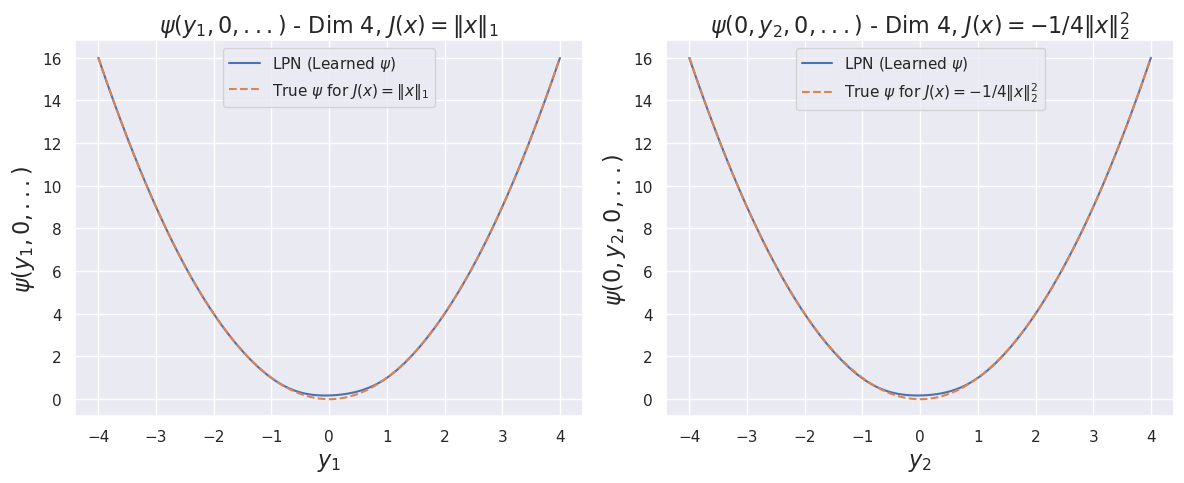

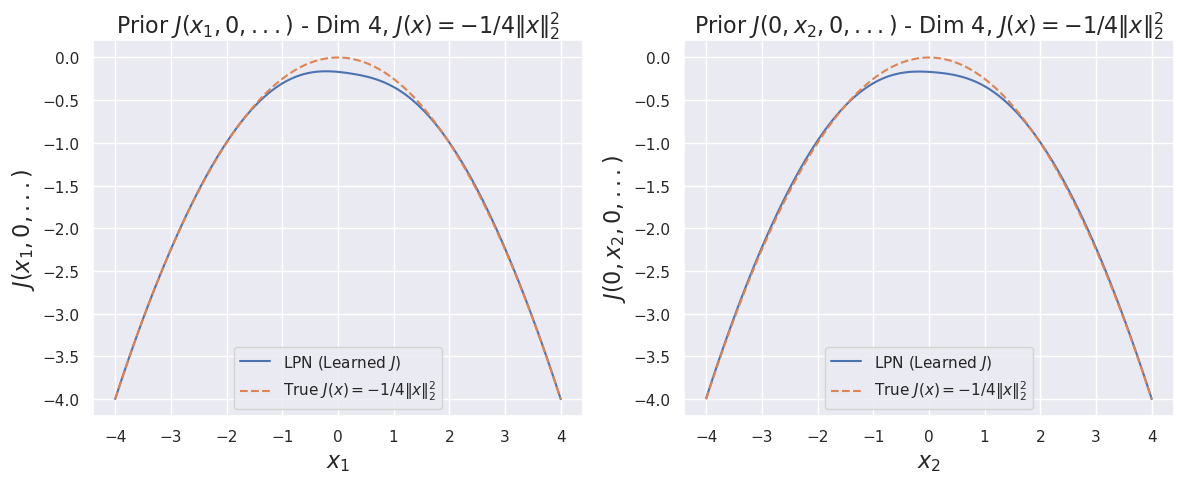

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.3324,  3.5255, -7.9438, -3.1572],
        [-5.6478, -6.5232, -5.0136, -2.4703],
        [-1.6653,  0.6151, -1.3000,  2.9821],
        ...,
        [ 6.8167, -2.3505,  1.0479, -3.8075],
        [-7.2363, -7.4198, -5.1919, -7.9079],
        [ 2.5784,  6.4760,  6.5781,  2.7297]], device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 572.3662719726562
iteration 0 loss 3113.15283203125


iteration 500 loss 17.520280838012695


iteration 1000 loss 4.898738384246826


iteration 1500 loss 0.19581307470798492


iteration 2000 loss 0.07229887694120407


iteration 2500 loss 0.038055334240198135


iteration 3000 loss 0.024493666365742683


iteration 3500 loss 0.04421892762184143


iteration 4000 loss 0.019367242231965065


iteration 4500 loss 0.013354440219700336


iteration 5000 loss 0.017408184707164764


iteration 5500 loss 0.009932594373822212


iteration 6000 loss 0.009834764525294304


iteration 6500 loss 0.006867204327136278


iteration 7000 loss 0.006824744865298271


iteration 7500 loss 0.005962591152638197


iteration 8000 loss 0.0442475862801075


iteration 8500 loss 0.045384228229522705


iteration 9000 loss 0.04356417804956436


iteration 9500 loss 0.6663393378257751


iteration 10000 loss 0.003631529165431857


iteration 10500 loss 0.0036280928179621696


iteration 11000 loss 0.004052078351378441


iteration 11500 loss 0.22915849089622498


iteration 12000 loss 0.0029787649400532246


iteration 12500 loss 0.003290040185675025


iteration 13000 loss 0.002653668634593487


iteration 13500 loss 0.0028157024644315243


iteration 14000 loss 0.05419966205954552


iteration 14500 loss 0.00259501114487648


iteration 15000 loss 0.34584730863571167


iteration 15500 loss 0.0024650897830724716


iteration 16000 loss 0.0020917323417961597


iteration 16500 loss 0.0024422884453088045


iteration 17000 loss 0.002007924485951662


iteration 17500 loss 0.005850873421877623


iteration 18000 loss 0.0020473566837608814


iteration 18500 loss 0.0018037372501567006


iteration 19000 loss 0.0024840766564011574


iteration 19500 loss 0.0019477674504742026


iteration 20000 loss 0.0017388537526130676


iteration 20500 loss 0.0029007133562117815


iteration 21000 loss 0.00184776377864182


iteration 21500 loss 0.0016352811362594366


iteration 22000 loss 0.005497901700437069


iteration 22500 loss 0.0018651094287633896


iteration 23000 loss 0.001664274139329791


iteration 23500 loss 0.0015132479602470994


iteration 24000 loss 0.001421582535840571


iteration 24500 loss 0.08981375396251678


iteration 25000 loss 0.001969977980479598


iteration 25500 loss 0.0016241164412349463


iteration 26000 loss 0.0014619902940467


iteration 26500 loss 0.0014016608474776149


iteration 27000 loss 0.0013465804513543844


iteration 27500 loss 0.0013005677610635757


iteration 28000 loss 0.0012478571152314544


iteration 28500 loss 0.0012183132348582149


iteration 29000 loss 0.012636484578251839


iteration 29500 loss 0.003969785291701555


iteration 30000 loss 0.001424152054823935


iteration 30500 loss 0.0013315546093508601


iteration 31000 loss 0.001294432207942009


iteration 31500 loss 0.0012480511795729399


iteration 32000 loss 0.0012279978254809976


iteration 32500 loss 0.0012011380167677999


iteration 33000 loss 0.0011687232181429863


iteration 33500 loss 0.0011306729866191745


iteration 34000 loss 0.0011062126141041517


iteration 34500 loss 0.0011004344560205936


iteration 35000 loss 0.0011005601845681667


iteration 35500 loss 0.0010855060536414385


iteration 36000 loss 0.0010737390257418156


iteration 36500 loss 0.0010674359509721398


iteration 37000 loss 0.0010587291326373816


iteration 37500 loss 0.0010545570403337479


iteration 38000 loss 0.0010409718379378319


iteration 38500 loss 0.0010185848223045468


iteration 39000 loss 0.0010003854986280203


iteration 39500 loss 0.000981335761025548


iteration 40000 loss 0.0009656507172621787


iteration 40500 loss 0.0009578174212947488


iteration 41000 loss 0.0009355719084851444


iteration 41500 loss 0.000935742340516299


iteration 42000 loss 0.0009392364299856126


iteration 42500 loss 0.0009387569152750075


iteration 43000 loss 0.0009585294756107032


iteration 43500 loss 0.0009629707201384008


iteration 44000 loss 0.0009469472570344806


iteration 44500 loss 0.0009005407337099314


iteration 45000 loss 0.0008836303604766726


iteration 45500 loss 0.0008824312244541943


iteration 46000 loss 0.0008836040506139398


iteration 46500 loss 0.0008807996637187898


iteration 47000 loss 0.000852550205308944


iteration 47500 loss 0.000855518679600209


iteration 48000 loss 0.0009149827528744936


iteration 48500 loss 0.006425713188946247


iteration 49000 loss 0.000793235725723207


iteration 49500 loss 0.000795713858678937


iteration 50000 loss 0.0007968462887220085


iteration 50500 loss 0.0007921563228592277


iteration 51000 loss 0.0007754997932352126


iteration 51500 loss 0.0007681336137466133


iteration 52000 loss 0.0007636500522494316


iteration 52500 loss 0.0007526573026552796


iteration 53000 loss 0.0007582683465443552


iteration 53500 loss 0.0007589446031488478


iteration 54000 loss 0.0007612216868437827


iteration 54500 loss 0.0007689518970437348


iteration 55000 loss 0.0007740533910691738


iteration 55500 loss 0.17820928990840912


iteration 56000 loss 0.02057800255715847


iteration 56500 loss 0.026432493701577187


iteration 57000 loss 0.02476651407778263


iteration 57500 loss 0.031571246683597565


iteration 58000 loss 0.0006977301673032343


iteration 58500 loss 0.0007015871233306825


iteration 59000 loss 0.000702971825376153


iteration 59500 loss 0.0007050451240502298


iteration 60000 loss 0.0007013766444288194


iteration 60500 loss 0.0006973749259486794


iteration 61000 loss 0.0006932967808097601


iteration 61500 loss 0.0006967605440877378


iteration 62000 loss 0.0007065594545565546


iteration 62500 loss 0.0007295624818652868


iteration 63000 loss 0.0007944573881104589


iteration 63500 loss 0.001008708612062037


iteration 64000 loss 0.0008550864877179265


iteration 64500 loss 0.0008753222064115107


iteration 65000 loss 0.0015484669711440802


iteration 65500 loss 0.008309546858072281


iteration 66000 loss 0.0008513475186191499


iteration 66500 loss 0.07878023386001587


iteration 67000 loss 0.0020777606405317783


iteration 67500 loss 0.005760265048593283


iteration 68000 loss 0.0010094502940773964


iteration 68500 loss 0.0007101696101017296


iteration 69000 loss 0.0009495835984125733


iteration 69500 loss 0.004753195680677891


iteration 70000 loss 0.0006447802297770977


iteration 70500 loss 0.03271785378456116


iteration 71000 loss 0.0008116660756058991


iteration 71500 loss 0.000765856122598052


iteration 72000 loss 0.0007148171425797045


iteration 72500 loss 0.0006659083883278072


iteration 73000 loss 0.0006603446672670543


iteration 73500 loss 0.0006493216496892273


iteration 74000 loss 0.0006337459781207144


iteration 74500 loss 0.0006136702140793204


iteration 75000 loss 0.0006019625579938293


iteration 75500 loss 0.0005933804204687476


iteration 76000 loss 0.0005858234944753349


iteration 76500 loss 0.000709586835000664


iteration 77000 loss 0.005808637943118811


iteration 77500 loss 0.0008007456781342626


iteration 78000 loss 0.0006889197393320501


iteration 78500 loss 0.0006234524771571159


iteration 79000 loss 0.0006046815542504191


iteration 79500 loss 0.0005838443757966161


iteration 80000 loss 0.000574371952097863


iteration 80500 loss 0.0005667585646733642


iteration 81000 loss 0.0005614378023892641


iteration 81500 loss 0.01164661068469286


iteration 82000 loss 0.0051384177058935165


iteration 82500 loss 0.0008375475881621242


iteration 83000 loss 0.0006087934598326683


iteration 83500 loss 0.0005861035897396505


iteration 84000 loss 0.0005751593271270394


iteration 84500 loss 0.0005687267985194921


iteration 85000 loss 0.0005702188354916871


iteration 85500 loss 0.0005755246966145933


iteration 86000 loss 0.0005864576087333262


iteration 86500 loss 0.0005968203186057508


iteration 87000 loss 0.0006000466528348625


iteration 87500 loss 0.0006013248348608613


iteration 88000 loss 0.0006136225420050323


iteration 88500 loss 0.011012250557541847


iteration 89000 loss 0.0010631073964759707


iteration 89500 loss 0.000530252989847213


iteration 90000 loss 0.0005307351239025593


iteration 90500 loss 0.0005305114900693297


iteration 91000 loss 0.0005296224262565374


iteration 91500 loss 0.0005277235759422183


iteration 92000 loss 0.0005199991283006966


iteration 92500 loss 0.0005191818345338106


iteration 93000 loss 0.0005155890248715878


iteration 93500 loss 0.0005166109185665846


iteration 94000 loss 0.0005102215800434351


iteration 94500 loss 0.0005099674453958869


iteration 95000 loss 0.0005104014417156577


iteration 95500 loss 0.0005112283397465944


iteration 96000 loss 0.0005113245570100844


iteration 96500 loss 0.0005173803074285388


iteration 97000 loss 0.0005181951564736664


iteration 97500 loss 0.0005176455597393215


iteration 98000 loss 0.000516864936798811


iteration 98500 loss 0.0005166674382053316


iteration 99000 loss 0.0005153199890628457


iteration 99500 loss 0.0005151054938323796


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0005138014676049352


iteration 100500 loss 0.0005078257527202368


iteration 101000 loss 0.0005017278017476201


iteration 101500 loss 0.0004954126197844744


iteration 102000 loss 0.0004887448158115149


iteration 102500 loss 0.000481569382827729


iteration 103000 loss 0.00047373236157000065


iteration 103500 loss 0.0004651206254493445


iteration 104000 loss 0.0004556023341137916


iteration 104500 loss 0.00044494474423117936


iteration 105000 loss 0.00043489373638294637


iteration 105500 loss 0.0004264855815563351


iteration 106000 loss 0.0004975413903594017


iteration 106500 loss 0.00041112746112048626


iteration 107000 loss 0.00046945171197876334


iteration 107500 loss 0.00039865609141997993


iteration 108000 loss 0.0003924282791558653


iteration 108500 loss 0.0003877755952998996


iteration 109000 loss 0.00038277110434137285


iteration 109500 loss 0.0003780737752094865


iteration 110000 loss 0.0003736234502866864


iteration 110500 loss 0.0003687713178806007


iteration 111000 loss 0.0003645782999228686


iteration 111500 loss 0.00036015291698276997


iteration 112000 loss 0.0003570037370081991


iteration 112500 loss 0.00035329730599187315


iteration 113000 loss 0.00034982580109499395


iteration 113500 loss 0.0003461382875684649


iteration 114000 loss 0.0003433520323596895


iteration 114500 loss 0.0003408408665563911


iteration 115000 loss 0.00033713181619532406


iteration 115500 loss 0.00033391875331290066


iteration 116000 loss 0.0003309680614620447


iteration 116500 loss 0.00032845191890373826


iteration 117000 loss 0.0003256977361161262


iteration 117500 loss 0.0003229796711821109


iteration 118000 loss 0.0003206615801900625


iteration 118500 loss 0.00031826962367631495


iteration 119000 loss 0.00550920469686389


iteration 119500 loss 0.000313835364067927


iteration 120000 loss 0.00031145120738074183


iteration 120500 loss 0.00030948029598221183


iteration 121000 loss 0.0003073916886933148


iteration 121500 loss 0.0005560945719480515


iteration 122000 loss 0.00030338644864968956


iteration 122500 loss 0.000301099760690704


iteration 123000 loss 0.00029933074256405234


iteration 123500 loss 0.00036231594276614487


iteration 124000 loss 0.0002955328964162618


iteration 124500 loss 0.001900297706015408


iteration 125000 loss 0.00029211066430434585


iteration 125500 loss 0.00029019525391049683


iteration 126000 loss 0.00028836505953222513


iteration 126500 loss 0.00028670745086856186


iteration 127000 loss 0.0002848111907951534


iteration 127500 loss 0.00028344857855699956


iteration 128000 loss 0.00030507479095831513


iteration 128500 loss 0.0002803739334922284


iteration 129000 loss 0.00027886751922778785


iteration 129500 loss 0.0002771047002170235


iteration 130000 loss 0.00027573827537707984


iteration 130500 loss 0.0015179394977167249


iteration 131000 loss 0.00027289247373118997


iteration 131500 loss 0.0002737352333497256


iteration 132000 loss 0.00026986663579009473


iteration 132500 loss 0.00029299233574420214


iteration 133000 loss 0.0002671301190275699


iteration 133500 loss 0.0011340663768351078


iteration 134000 loss 0.00026451845769770443


iteration 134500 loss 0.0002635432465467602


iteration 135000 loss 0.0002616041456349194


iteration 135500 loss 0.0002605461631901562


iteration 136000 loss 0.00025906911469064653


iteration 136500 loss 0.0002581353473942727


iteration 137000 loss 0.0002567431947682053


iteration 137500 loss 0.00025571550941094756


iteration 138000 loss 0.0002543901791796088


iteration 138500 loss 0.00025341977016068995


iteration 139000 loss 0.0002521892893128097


iteration 139500 loss 0.00025102647487074137


iteration 140000 loss 0.00025006369105540216


iteration 140500 loss 0.0002486238372512162


iteration 141000 loss 0.00024760569795034826


iteration 141500 loss 0.00024638191098347306


iteration 142000 loss 0.0002454064670018852


iteration 142500 loss 0.0002442216209601611


iteration 143000 loss 0.00024336671049240977


iteration 143500 loss 0.0002422398974886164


iteration 144000 loss 0.00024108857905957848


iteration 144500 loss 0.00024011572531890124


iteration 145000 loss 0.00023912607866805047


iteration 145500 loss 0.0002380122896283865


iteration 146000 loss 0.00023706046340521425


iteration 146500 loss 0.00023597280960530043


iteration 147000 loss 0.00023510899336542934


iteration 147500 loss 0.0002340181963518262


iteration 148000 loss 0.00023328018141910434


iteration 148500 loss 0.00023229002545122057


iteration 149000 loss 0.00023152970243245363


iteration 149500 loss 0.00023055641213431954


iteration 150000 loss 0.00022974517196416855


iteration 150500 loss 0.00022878484742250293


iteration 151000 loss 0.00022795524273533374


iteration 151500 loss 0.00022694424842484295


iteration 152000 loss 0.0002262462512589991


iteration 152500 loss 0.00022539251949638128


iteration 153000 loss 0.0007167409639805555


iteration 153500 loss 0.00022371501836460084


iteration 154000 loss 0.0035971037577837706


iteration 154500 loss 0.00022214517230167985


iteration 155000 loss 0.0002212527469964698


iteration 155500 loss 0.00022060968331061304


iteration 156000 loss 0.00021975190611556172


iteration 156500 loss 0.0002188341604778543


iteration 157000 loss 0.0002182648313464597


iteration 157500 loss 0.00021742038370575756


iteration 158000 loss 0.00021682714577764273


iteration 158500 loss 0.0002160324074793607


iteration 159000 loss 0.00021552319230977446


iteration 159500 loss 0.00021463679149746895


iteration 160000 loss 0.00376144889742136


iteration 160500 loss 0.00021324977569747716


iteration 161000 loss 0.00021255449973978102


iteration 161500 loss 0.00021179211034905165


iteration 162000 loss 0.0002111040084855631


iteration 162500 loss 0.00021031880169175565


iteration 163000 loss 0.00031211524037644267


iteration 163500 loss 0.00020884699188172817


iteration 164000 loss 0.00020830372523050755


iteration 164500 loss 0.0002075446245726198


iteration 165000 loss 0.00020701477478723973


iteration 165500 loss 0.00020620369468815625


iteration 166000 loss 0.00020573605434037745


iteration 166500 loss 0.00020495413627941161


iteration 167000 loss 0.000776567729189992


iteration 167500 loss 0.00020370437414385378


iteration 168000 loss 0.0002039204991888255


iteration 168500 loss 0.00020230903464835137


iteration 169000 loss 0.0002017282386077568


iteration 169500 loss 0.00020104383293073624


iteration 170000 loss 0.00020051731553394347


iteration 170500 loss 0.00020196460536681116


iteration 171000 loss 0.00019930080452468246


iteration 171500 loss 0.00019994183094240725


iteration 172000 loss 0.00019811748643405735


iteration 172500 loss 0.00019745351164601743


iteration 173000 loss 0.00019697830430231988


iteration 173500 loss 0.00019631719624157995


iteration 174000 loss 0.0001958140783244744


iteration 174500 loss 0.0001951588928932324


iteration 175000 loss 0.00019469231483526528


iteration 175500 loss 0.0001940275396918878


iteration 176000 loss 0.00019349098147358745


iteration 176500 loss 0.00019346106273587793


iteration 177000 loss 0.00019229216559324414


iteration 177500 loss 0.00019182456890121102


iteration 178000 loss 0.00019117686315439641


iteration 178500 loss 0.00019077684555668384


iteration 179000 loss 0.0004154948110226542


iteration 179500 loss 0.0001913297310238704


iteration 180000 loss 0.00018910648941528052


iteration 180500 loss 0.00018856894166674465


iteration 181000 loss 0.00018847925821319222


iteration 181500 loss 0.00018753079348243773


iteration 182000 loss 0.0005658881273120642


iteration 182500 loss 0.00018652832659427077


iteration 183000 loss 0.0005063242861069739


iteration 183500 loss 0.0001854450674727559


iteration 184000 loss 0.0001849096006480977


iteration 184500 loss 0.00018439855193719268


iteration 185000 loss 0.00018395532970316708


iteration 185500 loss 0.0001833735004765913


iteration 186000 loss 0.0001830175897339359


iteration 186500 loss 0.0006019158172421157


iteration 187000 loss 0.0001820670731831342


iteration 187500 loss 0.00018151848053094


iteration 188000 loss 0.0001811770925996825


iteration 188500 loss 0.0001806225482141599


iteration 189000 loss 0.00018017248657997698


iteration 189500 loss 0.00029239043942652643


iteration 190000 loss 0.0001791299000615254


iteration 190500 loss 0.002981872297823429


iteration 191000 loss 0.00020251463865861297


iteration 191500 loss 0.00017768448742572218


iteration 192000 loss 0.00017721843323670328


iteration 192500 loss 0.00017676658171694726


iteration 193000 loss 0.00017634652613196522


iteration 193500 loss 0.0001792343391571194


iteration 194000 loss 0.00017543633293826133


iteration 194500 loss 0.0001750676310621202


iteration 195000 loss 0.00017454595945309848


iteration 195500 loss 0.00017418048810213804


iteration 196000 loss 0.00017364670929964632


iteration 196500 loss 0.00017334397125523537


iteration 197000 loss 0.00021113395632710308


iteration 197500 loss 0.00017248500080313534


iteration 198000 loss 0.00017385218234267086


iteration 198500 loss 0.00017168924387078732


iteration 199000 loss 0.0003594720328692347


iteration 199500 loss 0.00017087531159631908


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00017410270811524242


iteration 200500 loss 0.0001704427704680711


iteration 201000 loss 0.00017036749341059476


iteration 201500 loss 0.00017028329602908343


iteration 202000 loss 0.00017017681966535747


iteration 202500 loss 0.00017004873370751739


iteration 203000 loss 0.00016988549032248557


iteration 203500 loss 0.00016968247655313462


iteration 204000 loss 0.00016941990179475397


iteration 204500 loss 0.00016909076657611877


iteration 205000 loss 0.000168669008417055


iteration 205500 loss 0.00016823837358970195


iteration 206000 loss 0.0001886004174593836


iteration 206500 loss 0.00016742429579608142


iteration 207000 loss 0.00016698695253580809


iteration 207500 loss 0.0001665906165726483


iteration 208000 loss 0.00016616225184407085


iteration 208500 loss 0.00016576738562434912


iteration 209000 loss 0.00016535901522729546


iteration 209500 loss 0.00016501109348610044


iteration 210000 loss 0.00016456888988614082


iteration 210500 loss 0.00016424788918811828


iteration 211000 loss 0.00016388430958613753


iteration 211500 loss 0.00016347042401321232


iteration 212000 loss 0.00016302685253322124


iteration 212500 loss 0.00016272695211227983


iteration 213000 loss 0.0001624735741643235


iteration 213500 loss 0.00016196772048715502


iteration 214000 loss 0.0001616397057659924


iteration 214500 loss 0.00016123888781294227


iteration 215000 loss 0.00016084068920463324


iteration 215500 loss 0.0001622070267330855


iteration 216000 loss 0.0001600729301571846


iteration 216500 loss 0.0001596918300492689


iteration 217000 loss 0.00015931147208902985


iteration 217500 loss 0.00015897146658971906


iteration 218000 loss 0.00015956639254000038


iteration 218500 loss 0.0001582808035891503


iteration 219000 loss 0.00015791598707437515


iteration 219500 loss 0.0001575755886733532


iteration 220000 loss 0.00015724670083727688


iteration 220500 loss 0.00015687457926105708


iteration 221000 loss 0.00015657307812944055


iteration 221500 loss 0.00015618991164956242


iteration 222000 loss 0.00015590300608891994


iteration 222500 loss 0.00015558957238681614


iteration 223000 loss 0.00015519422595389187


iteration 223500 loss 0.00015495126717723906


iteration 224000 loss 0.00015465111937373877


iteration 224500 loss 0.0001542826066724956


iteration 225000 loss 0.00015396873641293496


iteration 225500 loss 0.00015368344611488283


iteration 226000 loss 0.00015331878967117518


iteration 226500 loss 0.00015304621774703264


iteration 227000 loss 0.00015275372425094247


iteration 227500 loss 0.00015240960055962205


iteration 228000 loss 0.00015209258708637208


iteration 228500 loss 0.00015175611770246178


iteration 229000 loss 0.00015145409270189703


iteration 229500 loss 0.00015111896209418774


iteration 230000 loss 0.00015085015911608934


iteration 230500 loss 0.00015053030801936984


iteration 231000 loss 0.0001501976657891646


iteration 231500 loss 0.00014988420298323035


iteration 232000 loss 0.00014957640087231994


iteration 232500 loss 0.00014926711446605623


iteration 233000 loss 0.0001489562273491174


iteration 233500 loss 0.00014862927491776645


iteration 234000 loss 0.00014831186854280531


iteration 234500 loss 0.0001479920174460858


iteration 235000 loss 0.00014774348528590053


iteration 235500 loss 0.0001473533338867128


iteration 236000 loss 0.00014702706539537758


iteration 236500 loss 0.00014673902478534728


iteration 237000 loss 0.00014668432413600385


iteration 237500 loss 0.00014617745182476938


iteration 238000 loss 0.00014588441990781575


iteration 238500 loss 0.00014558837574440986


iteration 239000 loss 0.0001453491859138012


iteration 239500 loss 0.00014504733553621918


iteration 240000 loss 0.00014476948126684874


iteration 240500 loss 0.000144534875289537


iteration 241000 loss 0.00018834223737940192


iteration 241500 loss 0.0001439332409063354


iteration 242000 loss 0.00014367322728503495


iteration 242500 loss 0.00014338493929244578


iteration 243000 loss 0.00014310241385828704


iteration 243500 loss 0.00015099749725777656


iteration 244000 loss 0.00014255776477511972


iteration 244500 loss 0.00014226262283045799


iteration 245000 loss 0.00014200143050402403


iteration 245500 loss 0.0001417054154444486


iteration 246000 loss 0.00014145455497782677


iteration 246500 loss 0.00014115381054580212


iteration 247000 loss 0.00014092959463596344


iteration 247500 loss 0.00014065777941141278


iteration 248000 loss 0.0001403573405696079


iteration 248500 loss 0.0001401173503836617


iteration 249000 loss 0.0001398377207806334


iteration 249500 loss 0.0001395777944708243


iteration 250000 loss 0.00013929352280683815


iteration 250500 loss 0.00013904347724746913


iteration 251000 loss 0.00013876843149773777


iteration 251500 loss 0.00013853782729711384


iteration 252000 loss 0.00016089377459138632


iteration 252500 loss 0.00013802401372231543


iteration 253000 loss 0.00013774627586826682


iteration 253500 loss 0.00013749388745054603


iteration 254000 loss 0.000137424620334059


iteration 254500 loss 0.00013694551307708025


iteration 255000 loss 0.00013672099157702178


iteration 255500 loss 0.00013645800936501473


iteration 256000 loss 0.00013622900587506592


iteration 256500 loss 0.0001360029709758237


iteration 257000 loss 0.00013574137119576335


iteration 257500 loss 0.00013546373520512134


iteration 258000 loss 0.00013526008115150034


iteration 258500 loss 0.00013501211651600897


iteration 259000 loss 0.00013477022002916783


iteration 259500 loss 0.00013454323925543576


iteration 260000 loss 0.0001343016338068992


iteration 260500 loss 0.0001340856251772493


iteration 261000 loss 0.0001338418514933437


iteration 261500 loss 0.000133593610371463


iteration 262000 loss 0.00013341255544219166


iteration 262500 loss 0.00013318464334588498


iteration 263000 loss 0.000132944158394821


iteration 263500 loss 0.00013269635383039713


iteration 264000 loss 0.00013247305469121784


iteration 264500 loss 0.00013224489521235228


iteration 265000 loss 0.0001319960574619472


iteration 265500 loss 0.00013182012480683625


iteration 266000 loss 0.00013159948866814375


iteration 266500 loss 0.00013135914923623204


iteration 267000 loss 0.00013111757289152592


iteration 267500 loss 0.00013090342690702528


iteration 268000 loss 0.00013070418208371848


iteration 268500 loss 0.00013953869347460568


iteration 269000 loss 0.00013025022053625435


iteration 269500 loss 0.00021575593564193696


iteration 270000 loss 0.0001298113784287125


iteration 270500 loss 0.00012957875151187181


iteration 271000 loss 0.00012936846178490669


iteration 271500 loss 0.0001291588559979573


iteration 272000 loss 0.00012898011482320726


iteration 272500 loss 0.00012874591629952192


iteration 273000 loss 0.00012853390944655985


iteration 273500 loss 0.00012830845662392676


iteration 274000 loss 0.00012812545173801482


iteration 274500 loss 0.00012789297034032643


iteration 275000 loss 0.00012768476153723896


iteration 275500 loss 0.0001274572714464739


iteration 276000 loss 0.00012723615509457886


iteration 276500 loss 0.00012701937521342188


iteration 277000 loss 0.00012798978423234075


iteration 277500 loss 0.00012657666229642928


iteration 278000 loss 0.0001263619924429804


iteration 278500 loss 0.00012618662731256336


iteration 279000 loss 0.00012594244617503136


iteration 279500 loss 0.00012573442654684186


iteration 280000 loss 0.0001255201204912737


iteration 280500 loss 0.0001252934744115919


iteration 281000 loss 0.00012508215149864554


iteration 281500 loss 0.00012487958883866668


iteration 282000 loss 0.00012466663611121476


iteration 282500 loss 0.0001244739250978455


iteration 283000 loss 0.0001251644134754315


iteration 283500 loss 0.00012408653856255114


iteration 284000 loss 0.00012389550101943314


iteration 284500 loss 0.0001246481842827052


iteration 285000 loss 0.00012350892939139158


iteration 285500 loss 0.0001233203656738624


iteration 286000 loss 0.0001230996276717633


iteration 286500 loss 0.00012289642472751439


iteration 287000 loss 0.0001226727181347087


iteration 287500 loss 0.00012250361032783985


iteration 288000 loss 0.00012229796266183257


iteration 288500 loss 0.00012209746637381613


iteration 289000 loss 0.00012194392184028402


iteration 289500 loss 0.00012175125448266044


iteration 290000 loss 0.0001215460360981524


iteration 290500 loss 0.00012132774281781167


iteration 291000 loss 0.00012116137077100575


iteration 291500 loss 0.00012097840226488188


iteration 292000 loss 0.00012539948511403054


iteration 292500 loss 0.00012060884182574227


iteration 293000 loss 0.00012042123853461817


iteration 293500 loss 0.00012021732254652306


iteration 294000 loss 0.00012004002928733826


iteration 294500 loss 0.00011982874275417998


iteration 295000 loss 0.00011962105054408312


iteration 295500 loss 0.00011972822539974004


iteration 296000 loss 0.00011921834811801091


iteration 296500 loss 0.00011901272227987647


iteration 297000 loss 0.00011885676212841645


iteration 297500 loss 0.00011866745626321062


iteration 298000 loss 0.00011846225243061781


iteration 298500 loss 0.0001183073763968423


iteration 299000 loss 0.00011811345757450908


iteration 299500 loss 0.00011791728320531547


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00011777052714023739


iteration 300500 loss 0.00011775545863201842


iteration 301000 loss 0.0001177328813355416


iteration 301500 loss 0.00011770560377044603


iteration 302000 loss 0.00011766879470087588


iteration 302500 loss 0.0001176202276838012


iteration 303000 loss 0.00011755740706576034


iteration 303500 loss 0.00011747630196623504


iteration 304000 loss 0.00011736989836208522


iteration 304500 loss 0.00011723720672307536


iteration 305000 loss 0.00011706602526828647


iteration 305500 loss 0.0001168516610050574


iteration 306000 loss 0.00011669986270135269


iteration 306500 loss 0.00011650977103272453


iteration 307000 loss 0.00011631977395154536


iteration 307500 loss 0.00011611549416556954


iteration 308000 loss 0.00011595239629969001


iteration 308500 loss 0.00011578075645957142


iteration 309000 loss 0.00011557936522876844


iteration 309500 loss 0.00011543154687387869


iteration 310000 loss 0.00011524552974151447


iteration 310500 loss 0.00011506456939969212


iteration 311000 loss 0.00011486992298159748


iteration 311500 loss 0.00011470758909126744


iteration 312000 loss 0.00011453163460828364


iteration 312500 loss 0.00011435012856964022


iteration 313000 loss 0.00011418039503041655


iteration 313500 loss 0.0001139931264333427


iteration 314000 loss 0.00011383582022972405


iteration 314500 loss 0.00011368125706212595


iteration 315000 loss 0.00011347301915520802


iteration 315500 loss 0.00011328666005283594


iteration 316000 loss 0.00011313502182019874


iteration 316500 loss 0.00011294143769191578


iteration 317000 loss 0.00011278805322945118


iteration 317500 loss 0.00011260531027801335


iteration 318000 loss 0.00011244530469411984


iteration 318500 loss 0.00011228844959987327


iteration 319000 loss 0.00011303555947961286


iteration 319500 loss 0.00011196124251000583


iteration 320000 loss 0.00011179544526385143


iteration 320500 loss 0.00011162019654875621


iteration 321000 loss 0.0001114775295718573


iteration 321500 loss 0.00011129648191854358


iteration 322000 loss 0.00011114184599136934


iteration 322500 loss 0.00011097097012680024


iteration 323000 loss 0.00011080569674959406


iteration 323500 loss 0.00011063487181672826


iteration 324000 loss 0.00011046974395867437


iteration 324500 loss 0.00011033099872292951


iteration 325000 loss 0.00011015383643098176


iteration 325500 loss 0.00010999634105246514


iteration 326000 loss 0.00010982434469042346


iteration 326500 loss 0.00010967571142828092


iteration 327000 loss 0.0001095047700800933


iteration 327500 loss 0.00010934643796645105


iteration 328000 loss 0.00010920705244643614


iteration 328500 loss 0.00010902982467086986


iteration 329000 loss 0.0001088818971766159


iteration 329500 loss 0.00010870089317904785


iteration 330000 loss 0.00010857300367206335


iteration 330500 loss 0.00010841985931620002


iteration 331000 loss 0.00010824837227119133


iteration 331500 loss 0.00010812137043103576


iteration 332000 loss 0.00010795747948577628


iteration 332500 loss 0.00010780467709992081


iteration 333000 loss 0.00010764546459540725


iteration 333500 loss 0.00010748809290817007


iteration 334000 loss 0.00010732327791629359


iteration 334500 loss 0.00010717427358031273


iteration 335000 loss 0.00010701809515012428


iteration 335500 loss 0.0001068630299414508


iteration 336000 loss 0.00010673644283087924


iteration 336500 loss 0.00010657653183443472


iteration 337000 loss 0.00010642981214914471


iteration 337500 loss 0.00010629994358168915


iteration 338000 loss 0.00010613119229674339


iteration 338500 loss 0.00010599777306197211


iteration 339000 loss 0.00010583767289062962


iteration 339500 loss 0.00010569600999588147


iteration 340000 loss 0.00010556337656453252


iteration 340500 loss 0.0001053947999025695


iteration 341000 loss 0.00010526968981139362


iteration 341500 loss 0.00010511981963645667


iteration 342000 loss 0.00010496961476746947


iteration 342500 loss 0.00010483443475095555


iteration 343000 loss 0.00010467221727594733


iteration 343500 loss 0.00010454934817971662


iteration 344000 loss 0.00010439405014039949


iteration 344500 loss 0.00010425551590742543


iteration 345000 loss 0.00010410172399133444


iteration 345500 loss 0.0001039645794662647


iteration 346000 loss 0.00010382795153418556


iteration 346500 loss 0.0001036703833960928


iteration 347000 loss 0.00010355064296163619


iteration 347500 loss 0.00010339708387618884


iteration 348000 loss 0.00010326460323994979


iteration 348500 loss 0.00010311660298611969


iteration 349000 loss 0.00010298106644768268


iteration 349500 loss 0.00010284109157510102


iteration 350000 loss 0.00010269418999087065


iteration 350500 loss 0.00010257722897222266


iteration 351000 loss 0.00010242942516924813


iteration 351500 loss 0.00010230195039184764


iteration 352000 loss 0.00010217197996098548


iteration 352500 loss 0.00010201617260463536


iteration 353000 loss 0.00010190322063863277


iteration 353500 loss 0.0001017633403535001


iteration 354000 loss 0.00010162800026591867


iteration 354500 loss 0.00010151126480195671


iteration 355000 loss 0.00010136462515220046


iteration 355500 loss 0.00010124189429916441


iteration 356000 loss 0.00010111715528182685


iteration 356500 loss 0.0001009656916721724


iteration 357000 loss 0.00010085942631121725


iteration 357500 loss 0.00010072197619592771


iteration 358000 loss 0.00010058168118121102


iteration 358500 loss 0.0001004725054372102


iteration 359000 loss 0.00010033337457571179


iteration 359500 loss 0.00010020552872447297


iteration 360000 loss 0.00010008364915847778


iteration 360500 loss 9.993684943765402e-05


iteration 361000 loss 9.981836046790704e-05


iteration 361500 loss 9.96699309325777e-05


iteration 362000 loss 9.95558948488906e-05


iteration 362500 loss 9.942398173734546e-05


iteration 363000 loss 9.929338557412848e-05


iteration 363500 loss 9.917399438563734e-05


iteration 364000 loss 9.903073078021407e-05


iteration 364500 loss 9.891582158161327e-05


iteration 365000 loss 9.877249249257147e-05


iteration 365500 loss 9.866127220448107e-05


iteration 366000 loss 9.853771916823462e-05


iteration 366500 loss 9.840002894634381e-05


iteration 367000 loss 9.829518967308104e-05


iteration 367500 loss 9.815842349780723e-05


iteration 368000 loss 9.804273577174172e-05


iteration 368500 loss 9.792797936825082e-05


iteration 369000 loss 9.778641106095165e-05


iteration 369500 loss 9.767675510374829e-05


iteration 370000 loss 9.754444909049198e-05


iteration 370500 loss 9.742291877046227e-05


iteration 371000 loss 9.732288890518248e-05


iteration 371500 loss 9.719764784676954e-05


iteration 372000 loss 9.70705586951226e-05


iteration 372500 loss 9.695273911347613e-05


iteration 373000 loss 9.682137897470966e-05


iteration 373500 loss 9.669558494351804e-05


iteration 374000 loss 9.657181362854317e-05


iteration 374500 loss 9.646349644754082e-05


iteration 375000 loss 9.63283164310269e-05


iteration 375500 loss 9.622659126762301e-05


iteration 376000 loss 9.611486893845722e-05


iteration 376500 loss 9.60529432632029e-05


iteration 377000 loss 9.587663953425363e-05


iteration 377500 loss 9.575042349752039e-05


iteration 378000 loss 9.562843479216099e-05


iteration 378500 loss 9.549200331093743e-05


iteration 379000 loss 9.539130405755714e-05


iteration 379500 loss 9.527351357974112e-05


iteration 380000 loss 9.514275734545663e-05


iteration 380500 loss 9.504920308245346e-05


iteration 381000 loss 9.49301611399278e-05


iteration 381500 loss 9.480999869992957e-05


iteration 382000 loss 9.469997166888788e-05


iteration 382500 loss 9.469876385992393e-05


iteration 383000 loss 9.44716448429972e-05


iteration 383500 loss 9.435421088710427e-05


iteration 384000 loss 9.423604933544993e-05


iteration 384500 loss 9.413896623300388e-05


iteration 385000 loss 9.401624993188307e-05


iteration 385500 loss 9.39068995648995e-05


iteration 386000 loss 9.378863614983857e-05


iteration 386500 loss 9.36721553443931e-05


iteration 387000 loss 9.35657590162009e-05


iteration 387500 loss 9.343611600343138e-05


iteration 388000 loss 9.33423507376574e-05


iteration 388500 loss 9.322353434981778e-05


iteration 389000 loss 9.311269968748093e-05


iteration 389500 loss 9.30146052269265e-05


iteration 390000 loss 9.288573346566409e-05


iteration 390500 loss 9.278949437430128e-05


iteration 391000 loss 9.26763896131888e-05


iteration 391500 loss 9.255903569282964e-05


iteration 392000 loss 9.245399996871129e-05


iteration 392500 loss 9.265357948606834e-05


iteration 393000 loss 9.223953384207562e-05


iteration 393500 loss 9.213128942064941e-05


iteration 394000 loss 9.201617649523541e-05


iteration 394500 loss 9.191555727738887e-05


iteration 395000 loss 9.178684558719397e-05


iteration 395500 loss 9.169842815026641e-05


iteration 396000 loss 9.159006003756076e-05


iteration 396500 loss 9.147669334197417e-05


iteration 397000 loss 9.137987217400223e-05


iteration 397500 loss 9.125621727434918e-05


iteration 398000 loss 9.116518776863813e-05


iteration 398500 loss 9.106253128265962e-05


iteration 399000 loss 9.094010601984337e-05


iteration 399500 loss 9.085775673156604e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 9.075219713849947e-05


iteration 400500 loss 9.074160334421322e-05


iteration 401000 loss 9.072624379768968e-05


iteration 401500 loss 9.070597297977656e-05


iteration 402000 loss 9.068078361451626e-05


iteration 402500 loss 9.064815822057426e-05


iteration 403000 loss 9.060605225386098e-05


iteration 403500 loss 9.055333794094622e-05


iteration 404000 loss 9.048881474882364e-05


iteration 404500 loss 9.041003067977726e-05


iteration 405000 loss 9.031830268213525e-05


iteration 405500 loss 9.021683945320547e-05


iteration 406000 loss 9.011866495711729e-05


iteration 406500 loss 9.001790022011846e-05


iteration 407000 loss 8.991893264465034e-05


iteration 407500 loss 8.982104191090912e-05


iteration 408000 loss 8.972127398010343e-05


iteration 408500 loss 8.962425636127591e-05


iteration 409000 loss 8.952651114668697e-05


iteration 409500 loss 8.942889689933509e-05


iteration 410000 loss 8.933167555369437e-05


iteration 410500 loss 8.923438872443512e-05


iteration 411000 loss 8.913828787626699e-05


iteration 411500 loss 8.904228889150545e-05


iteration 412000 loss 8.894822531146929e-05


iteration 412500 loss 8.885066927177832e-05


iteration 413000 loss 8.875547064235434e-05


iteration 413500 loss 8.865851123118773e-05


iteration 414000 loss 8.85641056811437e-05


iteration 414500 loss 8.846852870192379e-05


iteration 415000 loss 8.83742468431592e-05


iteration 415500 loss 8.828058344079182e-05


iteration 416000 loss 8.818692731438205e-05


iteration 416500 loss 8.80926672834903e-05


iteration 417000 loss 8.799960050964728e-05


iteration 417500 loss 8.7905274995137e-05


iteration 418000 loss 8.781290671322495e-05


iteration 418500 loss 8.772184082772583e-05


iteration 419000 loss 8.762951620155945e-05


iteration 419500 loss 8.753727161092684e-05


iteration 420000 loss 8.744563820073381e-05


iteration 420500 loss 8.735419396543875e-05


iteration 421000 loss 8.726153464522213e-05


iteration 421500 loss 8.717103628441691e-05


iteration 422000 loss 8.70793082867749e-05


iteration 422500 loss 8.699011232238263e-05


iteration 423000 loss 8.689989772392437e-05


iteration 423500 loss 8.680965402163565e-05


iteration 424000 loss 8.671882096678019e-05


iteration 424500 loss 8.662992331665009e-05


iteration 425000 loss 8.654086559545249e-05


iteration 425500 loss 8.645097113912925e-05


iteration 426000 loss 8.636257553007454e-05


iteration 426500 loss 8.627443457953632e-05


iteration 427000 loss 8.618551510153338e-05


iteration 427500 loss 8.609691576566547e-05


iteration 428000 loss 8.601034642197192e-05


iteration 428500 loss 8.592254016548395e-05


iteration 429000 loss 8.583478484069929e-05


iteration 429500 loss 8.574657113058493e-05


iteration 430000 loss 8.56596598168835e-05


iteration 430500 loss 8.557210094295442e-05


iteration 431000 loss 8.548580080969259e-05


iteration 431500 loss 8.540068665752187e-05


iteration 432000 loss 8.531478670192882e-05


iteration 432500 loss 8.522963616997004e-05


iteration 433000 loss 8.51424629217945e-05


iteration 433500 loss 8.505734876962379e-05


iteration 434000 loss 8.497150702169165e-05


iteration 434500 loss 8.488937601214275e-05


iteration 435000 loss 8.480472024530172e-05


iteration 435500 loss 8.471848559565842e-05


iteration 436000 loss 8.46341936266981e-05


iteration 436500 loss 8.455076749669388e-05


iteration 437000 loss 8.446844731224701e-05


iteration 437500 loss 8.438303484581411e-05


iteration 438000 loss 8.429960143985227e-05


iteration 438500 loss 8.421684469794855e-05


iteration 439000 loss 8.413213799940422e-05


iteration 439500 loss 8.405037806369364e-05


iteration 440000 loss 8.396877819905058e-05


iteration 440500 loss 8.388560672756284e-05


iteration 441000 loss 8.380282088182867e-05


iteration 441500 loss 8.372139564016834e-05


iteration 442000 loss 8.363895176444203e-05


iteration 442500 loss 8.355736645171419e-05


iteration 443000 loss 8.347580296685919e-05


iteration 443500 loss 8.339539635926485e-05


iteration 444000 loss 8.331479330081493e-05


iteration 444500 loss 8.323328074766323e-05


iteration 445000 loss 8.315294689964503e-05


iteration 445500 loss 8.30720309750177e-05


iteration 446000 loss 8.299208275275305e-05


iteration 446500 loss 8.291294216178358e-05


iteration 447000 loss 8.283231727546081e-05


iteration 447500 loss 8.275324944406748e-05


iteration 448000 loss 8.267457451438531e-05


iteration 448500 loss 8.25953611638397e-05


iteration 449000 loss 8.251498366007581e-05


iteration 449500 loss 8.243470074376091e-05


iteration 450000 loss 8.235689165303484e-05


iteration 450500 loss 8.227745274780318e-05


iteration 451000 loss 8.219968731282279e-05


iteration 451500 loss 8.212224201997742e-05


iteration 452000 loss 8.204631740227342e-05


iteration 452500 loss 8.196647831937298e-05


iteration 453000 loss 8.18877451820299e-05


iteration 453500 loss 8.18094122223556e-05


iteration 454000 loss 8.173063542926684e-05


iteration 454500 loss 8.165150211425498e-05


iteration 455000 loss 8.157545380527154e-05


iteration 455500 loss 8.149670611601323e-05


iteration 456000 loss 8.141952275764197e-05


iteration 456500 loss 8.134142262861133e-05


iteration 457000 loss 8.126542525133118e-05


iteration 457500 loss 8.118713594740257e-05


iteration 458000 loss 8.110952330753207e-05


iteration 458500 loss 8.103537402348593e-05


iteration 459000 loss 8.095864177448675e-05


iteration 459500 loss 8.088238973869011e-05


iteration 460000 loss 8.08048207545653e-05


iteration 460500 loss 8.072836499195546e-05


iteration 461000 loss 8.06513853603974e-05


iteration 461500 loss 8.057521336013451e-05


iteration 462000 loss 8.04979499662295e-05


iteration 462500 loss 8.042281842790544e-05


iteration 463000 loss 8.034582424443215e-05


iteration 463500 loss 8.02704889792949e-05


iteration 464000 loss 8.01948772277683e-05


iteration 464500 loss 8.012013859115541e-05


iteration 465000 loss 8.004475239431486e-05


iteration 465500 loss 7.996840577106923e-05


iteration 466000 loss 7.989302685018629e-05


iteration 466500 loss 7.981871021911502e-05


iteration 467000 loss 7.974449545145035e-05


iteration 467500 loss 7.966911653056741e-05


iteration 468000 loss 7.95945743448101e-05


iteration 468500 loss 7.951951556606218e-05


iteration 469000 loss 7.944451499497518e-05


iteration 469500 loss 7.93717335909605e-05


iteration 470000 loss 7.929714774945751e-05


iteration 470500 loss 7.922318764030933e-05


iteration 471000 loss 7.914833258837461e-05


iteration 471500 loss 7.907663530204445e-05


iteration 472000 loss 7.900261698523536e-05


iteration 472500 loss 7.892928260844201e-05


iteration 473000 loss 7.885717786848545e-05


iteration 473500 loss 7.878373435232788e-05


iteration 474000 loss 7.870955596445128e-05


iteration 474500 loss 7.863689825171605e-05


iteration 475000 loss 7.856504817027599e-05


iteration 475500 loss 7.849223038647324e-05


iteration 476000 loss 7.841901242500171e-05


iteration 476500 loss 7.834690768504515e-05


iteration 477000 loss 7.827428635209799e-05


iteration 477500 loss 7.820305472705513e-05


iteration 478000 loss 7.813123374944553e-05


iteration 478500 loss 7.80593472882174e-05


iteration 479000 loss 7.79879410401918e-05


iteration 479500 loss 7.791621465003118e-05


iteration 480000 loss 7.784527406329289e-05


iteration 480500 loss 7.777342398185283e-05


iteration 481000 loss 7.770306547172368e-05


iteration 481500 loss 7.763077883282676e-05


iteration 482000 loss 7.75602093199268e-05


iteration 482500 loss 7.748966163489968e-05


iteration 483000 loss 7.741972513031214e-05


iteration 483500 loss 7.734941755188629e-05


iteration 484000 loss 7.727788761258125e-05


iteration 484500 loss 7.720824214629829e-05


iteration 485000 loss 7.713800005149096e-05


iteration 485500 loss 7.706767792114988e-05


iteration 486000 loss 7.699774141656235e-05


iteration 486500 loss 7.692797953495756e-05


iteration 487000 loss 7.685862510697916e-05


iteration 487500 loss 7.678962720092386e-05


iteration 488000 loss 7.672079664189368e-05


iteration 488500 loss 7.665029988856986e-05


iteration 489000 loss 7.658108370378613e-05


iteration 489500 loss 7.651334453839809e-05


iteration 490000 loss 7.644377183169127e-05


iteration 490500 loss 7.637487578904256e-05


iteration 491000 loss 7.630576874362305e-05


iteration 491500 loss 7.623821147717535e-05


iteration 492000 loss 7.616965740453452e-05


iteration 492500 loss 7.610145257785916e-05


iteration 493000 loss 7.603344420203939e-05


iteration 493500 loss 7.596497016493231e-05


iteration 494000 loss 7.58967871661298e-05


iteration 494500 loss 7.582872058264911e-05


iteration 495000 loss 7.576217467430979e-05


iteration 495500 loss 7.569399895146489e-05


iteration 496000 loss 7.562591781606898e-05


iteration 496500 loss 7.555881893495098e-05


iteration 497000 loss 7.54921929910779e-05


iteration 497500 loss 7.542521052528173e-05


iteration 498000 loss 7.535851909779012e-05


iteration 498500 loss 7.529260619776323e-05


iteration 499000 loss 7.522424130002037e-05


iteration 499500 loss 7.515704783145338e-05


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


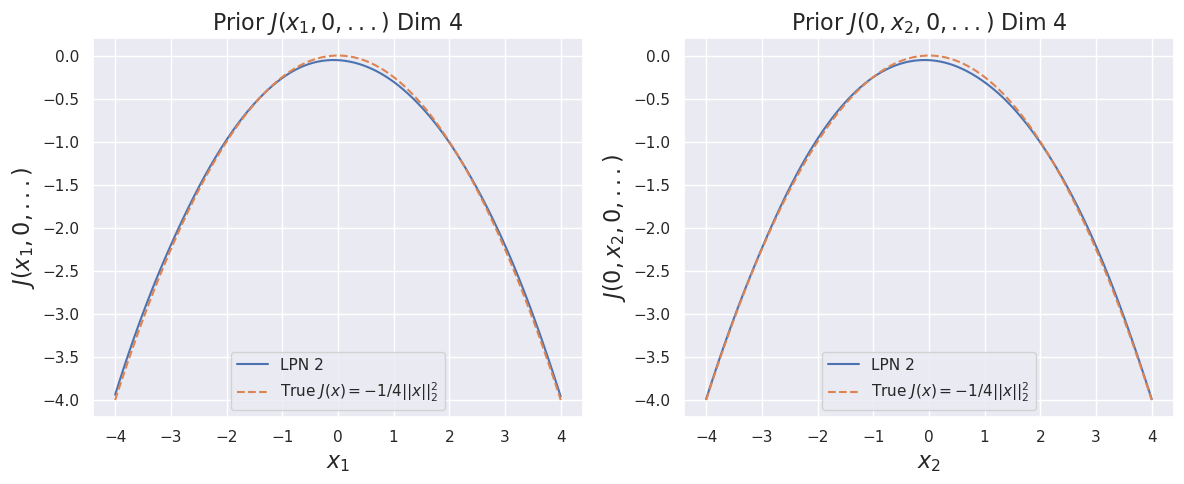

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)